## Forecasting EV Charging Demand in Perth (AUS) with Long Short-Term Memory Network

## Table of Contents
* [1. Introduction](#chapter1)
* [2. Data processing](#chapter2)
* [3. Model Implementation](##chapter3)
    * [3.1 Daily Model Implementation](#chapter3.1)
    * [3.2 Weekly Model Implementation](#chapter3.2)
    * [3.2 Monthly Model Implementation](#chapter3.3)
* [4. Conclusion](#chapter4)

## 1. Introduction

This notebook goes through the process of training LSTM for Perth. It uses dataset containing around 4 years of charging records in the city of Perth. The model is trained to predict single next observation based on the previous records. The predictions are made on daily, weekly and monthly level to reflect companies needs for both short-term and long-term planning. Models are trained on each of the stations separately to achieve better performance.

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## 2. Data processing

Data comes in 3 different files which are merged together here. Some of the stations are renamed to avoid duplicates.

In [75]:
df_1 = pd.read_csv('EV_ChargeStation_Use_Sept_2016_to_Aug_2017.csv', index_col=[0]).drop(columns=['OBJECTID'])
df_2 = pd.read_csv('EVChargeStationUseSept2017toAug2018.csv', index_col=[0])
df_3 = pd.read_csv('EVChargeStationUseSept2018toAug2019.csv', index_col=[0])

df_1 = df_1[df_1['Site'] != '***TEST SITE*** Charge Your Car HQ']
df_3 = df_3[df_3['Site'] != '***TEST SITE*** Charge Your Car HQ']

In [76]:
# Define a mapping dictionary for renaming
rename_mapping = {
    'King Street Car Park, Crieff': 'King Street Car Park',
    'Broxden Park & Ride, Perth': 'Broxden Park & Ride',
    'Canal Street Car Park 3rd floor, Perth': 'Canal Street Car Park',
    'Canal Street Car Park 3rd floor ': 'Canal Street Car Park',
    'Friarton Depot, Perth': 'Friarton Depot',
    'South Inch Car Park, Perth': 'South Inch Car Park',
    'Kinross Park and Ride, Kinross': 'Kinross Park and Ride',
    ' Leslie Street Car Park, Blairgowrie': 'Leslie Street Car Park, Blairgowrie',
}

# Replace the values in the 'Site' column using the mapping
df_1['Site'] = df_1['Site'].replace(rename_mapping)
df_2['Site'] = df_2['Site'].replace(rename_mapping)
df_3['Site'] = df_3['Site'].replace(rename_mapping)

df_1 = df_1.rename(columns={
    'CP_ID': 'CP ID',
    'Start_Date': 'Start Date',
    'Start_Time': 'Start Time',
    'End_Date': 'End Date',
    'End_Time': 'End Time',
    'Total_kWh': 'Total kWh'
})

# Dates
df_1['Date'] = pd.to_datetime(df_1['Start Date'].str[:10], errors='coerce')
df_2['Date'] = pd.to_datetime(df_2['Start Date'].str[:10], errors='coerce')
df_3['Date'] = pd.to_datetime(df_3['Start Date'].str[:10], errors='coerce')

# Union data
df = pd.concat([df_1, df_2, df_3]).drop_duplicates()

# Drop records with below 0 Total kWh
df = df[df['Total kWh'] >= 0]

# Drop two stations (too little data)
df = df[df['Site'] != 'Market Square Alyth']
df = df[df['Site'] != 'Mill Street, Perth']

In [78]:
# split data per station
stations = df['Site'].unique()
stations_dict = {}

for station in stations:
    stations_dict[station] = {'data':pd.DataFrame(), 'daily':pd.DataFrame(), 'weekly':pd.DataFrame(), 'monthly':pd.DataFrame()}
    stations_dict[station]['data'] = df[df['Site'] == station]

In [79]:
for station in stations:
    print(station)
    df_temp = stations_dict[station]['data'].copy()
    
    df_temp['Date'] = pd.to_datetime(df_temp['Date'])
    df_temp['Year-Month'] = df_temp['Date'].dt.strftime('%Y-%m')

    # Define the start date and end date
    start_date = df_temp['Date'].min()
    end_date = df_temp['Date'].max()

    # Calculate the number of weeks from the start date for each date
    df_temp['Week_index'] = (df_temp['Date'] - start_date).dt.days // 7

    stations_dict[station]['data'] = df_temp

Broxden Park & Ride
Crown Inn Wynd Car Park, Auchterarder
South Inch Car Park
Kinross Park and Ride
Leslie Street Car Park, Blairgowrie
Canal Street Car Park
King Street Car Park
Moness Terrace Car Park, Aberfeldy
Atholl Street Car Park, Dunkeld
Rie-Achan Road Car Park, Pitlochry
Friarton Depot


There are 11 different stations. Model will be trained to predict each of the stations energy demand separately.

Each timeframe model (daily, weekly, monthly) requires appropriately grouped data. The following sections process the data so that each of the records represents one observation (e.g. summed energy demand from all chargings for a day). Unlike in case of Palo Alto, Perth dataset contains quiety significant number of missing observations. This data quality problem is caused by technical reasons therefore it has been decided that those values should be filled with rolling average of 5 previous observations (or mean for the whole dataset for the first five observations). This issue will certainly impact the predictions.

In [80]:
for station in stations:

    df_temp = stations_dict[station]['data'].copy()
    daily = df_temp.groupby(['Date', 'Site'])['Total kWh'].sum().reset_index()

    # Define the complete date range
    start_date = df_temp['Date'].min()
    end_date = df_temp['Date'].max()
    date_range = pd.date_range(start=start_date, end=end_date)

    station_data = pd.DataFrame({'Date': date_range, 'Site': station})

    # Merge the complete data with the daily DataFrame to fill in missing values with 0
    daily_merged = pd.merge(station_data, daily, on=['Date', 'Site'], how='left')

    # Use mean for filling missing data 
    mean_energy = daily_merged['Total kWh'].mean()
    rolling_mean_energy = daily_merged['Total kWh'].rolling(window=5).mean().shift(1).fillna(mean_energy)
    daily_merged['Total kWh'] = daily_merged['Total kWh'].fillna(rolling_mean_energy)

    stations_dict[station]['daily'] = daily_merged

In [81]:
for station in stations:

    df_temp = stations_dict[station]['data'].copy()
    
    # Group by Week_index and Station Name to get weekly energy consumption
    weekly = df_temp.groupby(['Week_index', 'Site'])['Total kWh'].sum().reset_index()

    # Define the complete week index range
    start_week = df_temp['Week_index'].min()
    end_week = df_temp['Week_index'].max()
    week_range = range(start_week, end_week + 1)

    station_data = pd.DataFrame({'Week_index': week_range, 'Site': station})

    # Merge the complete data with the weekly DataFrame to fill in missing values with 0
    weekly_merged = pd.merge(station_data, weekly, on=['Week_index', 'Site'], how='left')

    # Use mean for filling missing data 
    mean_energy = weekly_merged['Total kWh'].mean()
    rolling_mean_energy = weekly_merged['Total kWh'].rolling(window=5).mean().shift(1).fillna(mean_energy)
    weekly_merged['Total kWh'] = weekly_merged['Total kWh'].fillna(rolling_mean_energy)

    # Use mean for filling missing data
    stations_dict[station]['weekly'] = weekly_merged

In [82]:
for station in stations:
    df_temp = stations_dict[station]['data'].copy()
    
    # Group by 'Year-Month' and 'Station Name' to get monthly energy consumption
    monthly = df_temp.groupby(['Year-Month', 'Site'])['Total kWh'].sum().reset_index()

    # Define the complete 'Year-Month' range
    start_year_month = df_temp['Year-Month'].min()
    end_year_month = df_temp['Year-Month'].max()
    year_month_range = pd.date_range(start=start_year_month, end=end_year_month, freq='MS').strftime('%Y-%m')

    station_data = pd.DataFrame({'Year-Month': year_month_range, 'Site': station})

    # Merge the complete data with the monthly DataFrame to fill in missing values with 0
    monthly_merged = pd.merge(station_data, monthly, on=['Year-Month', 'Site'], how='left')
    
    # Use mean for filling missing data 
    mean_energy = monthly_merged['Total kWh'].mean()
    rolling_mean_energy = monthly_merged['Total kWh'].rolling(window=5).mean().shift(1).fillna(mean_energy)
    monthly_merged['Total kWh'] = monthly_merged['Total kWh'].fillna(rolling_mean_energy)


    stations_dict[station]['monthly'] = monthly_merged

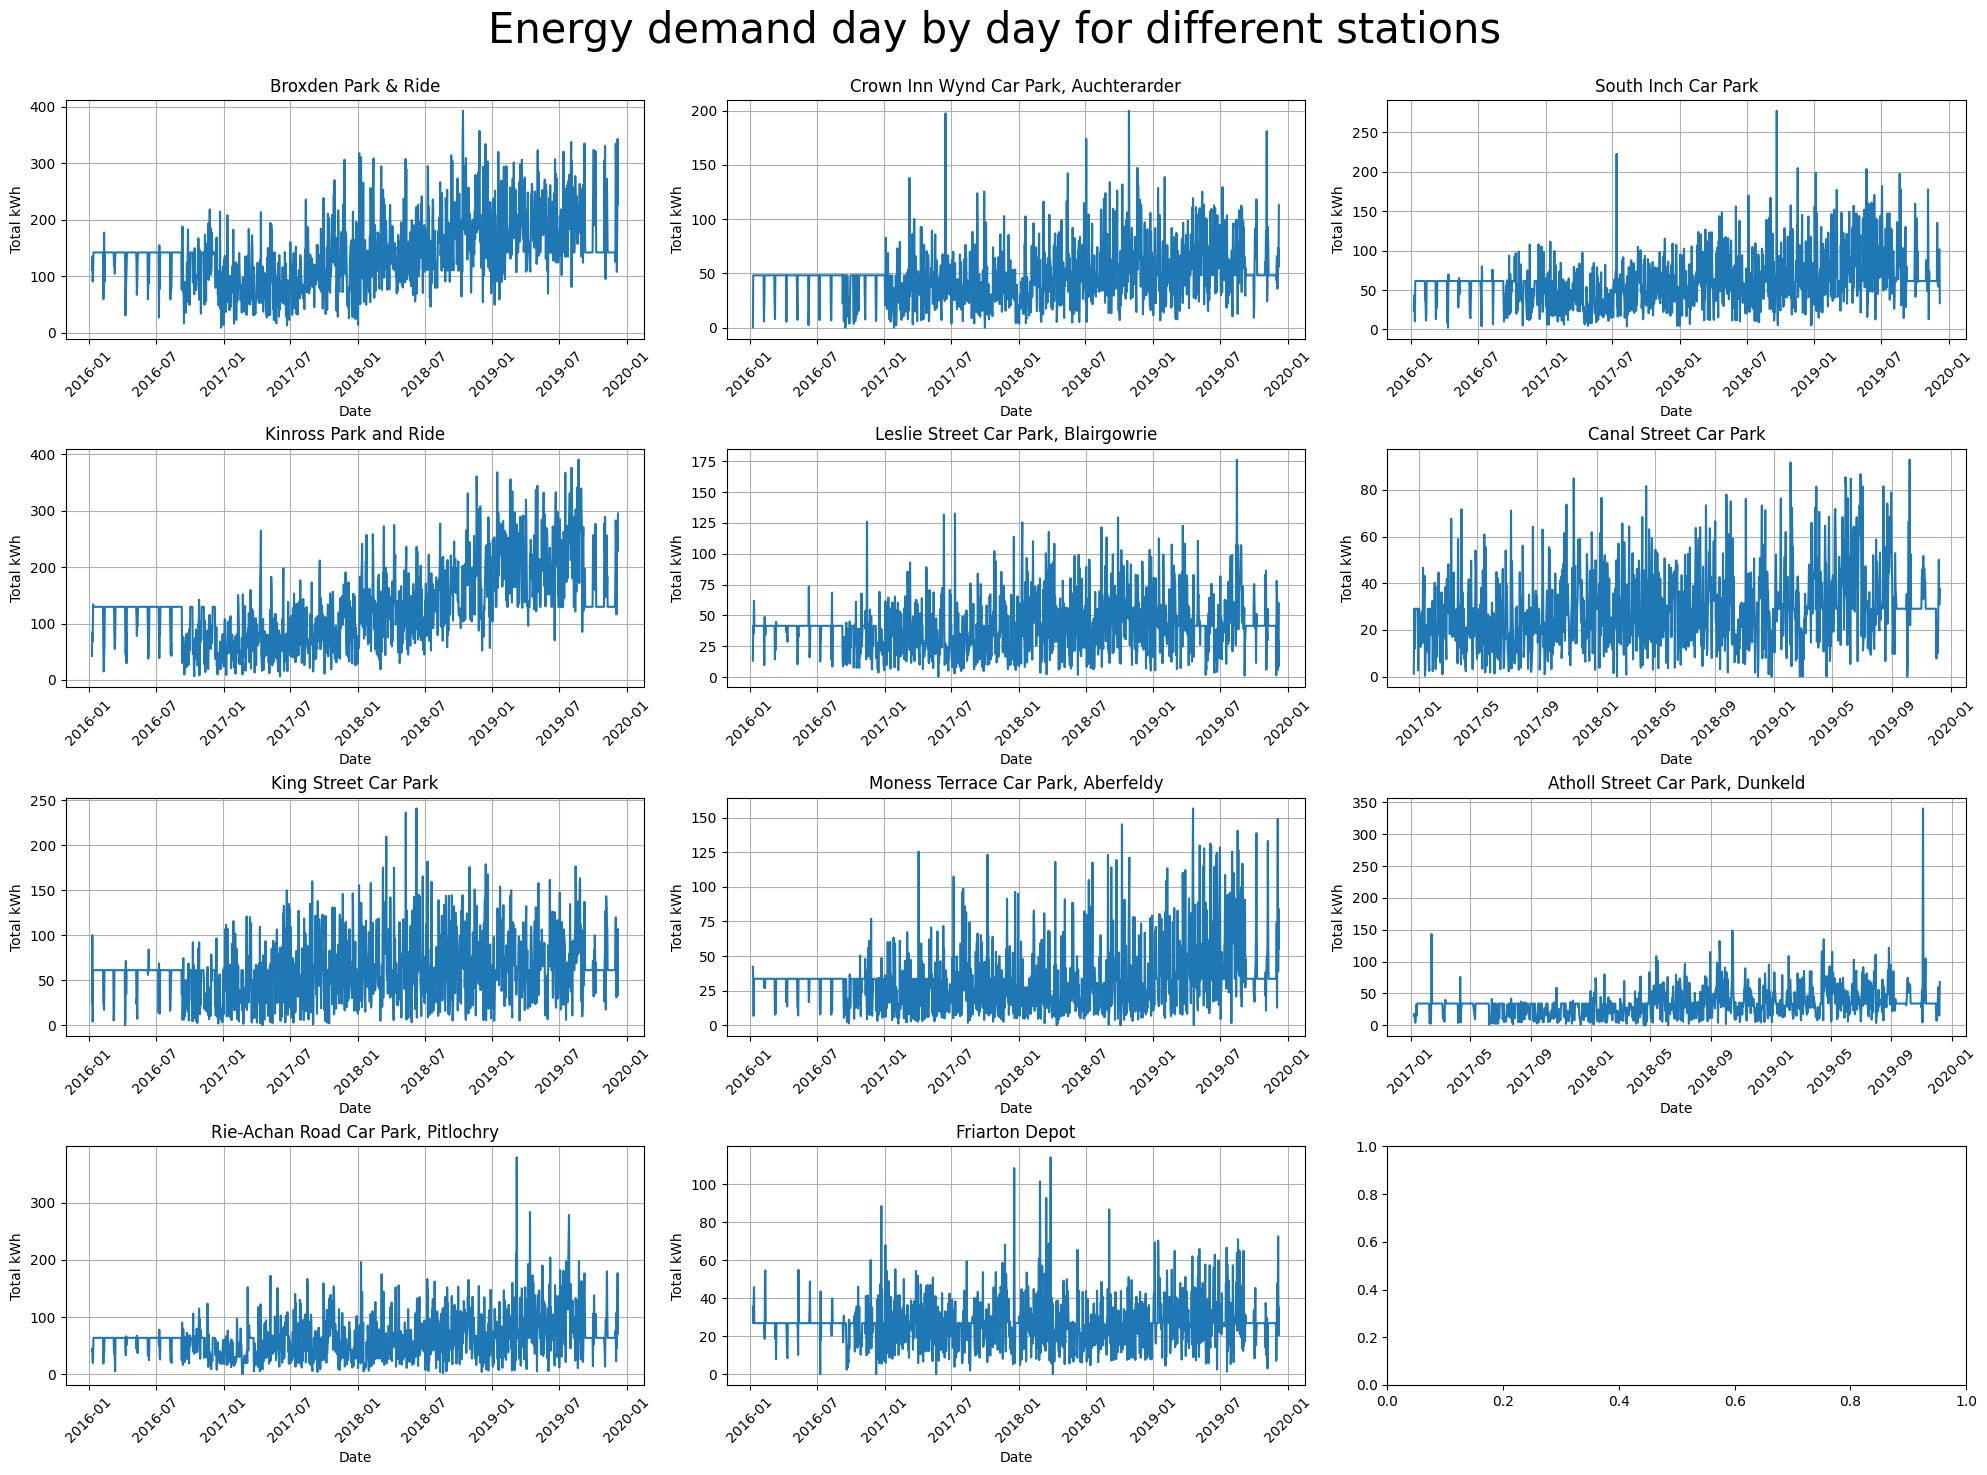

In [88]:
# Define the number of rows and columns for the subplots
num_rows = 4
num_cols = 3

# Create a figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 15))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Iterate over each station and plot on a separate subplot
for i, station in enumerate(stations):
    plot_df = stations_dict[station]['daily']
    ax = axs[i]
    ax.plot(plot_df['Date'], plot_df['Total kWh'])
    ax.set_title(station)
    ax.set_xlabel('Date')
    ax.set_ylabel('Total kWh')
    ax.grid(True)
    plt.setp(ax.get_xticklabels(), rotation=45)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Energy demand day by day for different stations', fontsize=30)
plt.show()

It can be seen that there are long periods with lacking observations (those have been filled by average). Energy consumption varies a lot between the days. Increasing demand trends are observed for all the stations. Its hard to recognize any cyclic behaviour of the data which makes the prediction task difficult. The model is expected to perform worse than Palo Alto one.

## 3. Model Implementation

The network will contain an lstm layer and a linear layer on top of it. The model is further initiated in the train function with `input_size` = 1 as it aims at predicting the single next observation, `hidden_size` = 64 indicating number of neurons in the hidden layer, `num_layer` = 1 as only one lstm layer is used. Dropout of `0.5` is also implemented to help with the regularization by randomly deactivating portion of the neurons in the hidden layer.

In [90]:
class LSTMModel(nn.Module):
      # input_size : number of features in input at each time step
      # hidden_size : Number of LSTM units 
      # num_layers : number of LSTM layers 
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x): # defines forward pass of the neural network
        out, _ = self.lstm(x)
        # extract only the last time step
        out = out[:, -1, :]
        out = self.linear(out)
        return out

In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


The following training loop performs the following operations: 
- scales the data to 0-1, 
- creates a sequence of chosen length reflecting the lookback period
- split data into train and test sets
- initiates model
- trains the model evaluating both train and test error
- saves necessary outputs

In [99]:
def train_lstm(df_dict, type, sequence_length, stations, num_epochs, predictions_dict, test_obs):
    for station in stations:
        print('\n', station, '\n')
        temp_df = df_dict[station][type]['Total kWh']

        # Scaling dataset
        reshaped_data = np.reshape(temp_df, (-1,1))
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = scaler.fit_transform(reshaped_data)

        # Create sequences and labels for training data
        sequence_length = sequence_length  # Number of time steps to look back
        X, y = [], []
        for i in range(len(scaled_data) - sequence_length):
            X.append(scaled_data[i:i+sequence_length])
            y.append(scaled_data[i+sequence_length])
        X, y = np.array(X), np.array(y)

        # Splitting the dataset
        X_train = X[:-test_obs]
        y_train = y[:-test_obs]
        X_test = X[-test_obs:]
        y_test = y[-test_obs:]
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
        # Convert data to PyTorch tensors
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32)
        X_test = torch.tensor(X_test, dtype=torch.float32)
        y_test = torch.tensor(y_test, dtype=torch.float32)
        X_train.shape,y_train.shape

        input_size = 1
        num_layers = 1
        hidden_size = 64
        
        # Define the model, loss function, and optimizer
        model = LSTMModel(input_size, hidden_size, num_layers).to(device)
        
        loss_fn = torch.nn.MSELoss(reduction='mean')
        
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        batch_size = 15
        # Create DataLoader for batch training
        train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        
        # Create DataLoader for batch training
        test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        num_epochs = num_epochs
        train_hist = []
        test_hist = []
        # Training loop
        for epoch in range(num_epochs):
            total_loss = 0.0

            # Training
            model.train()
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                predictions = model(batch_X)
                loss = loss_fn(predictions, batch_y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            # Calculate average training loss and accuracy
            average_loss = total_loss / len(train_loader)
            train_hist.append(average_loss)

            # Validation on test data
            model.eval()
            with torch.no_grad():
                total_test_loss = 0.0

                for batch_X_test, batch_y_test in test_loader:
                    batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
                    predictions_test = model(batch_X_test)
                    test_loss = loss_fn(predictions_test, batch_y_test)

                    total_test_loss += test_loss.item()

                # Calculate average test loss and accuracy
                average_test_loss = total_test_loss / len(test_loader)
                test_hist.append(average_test_loss)
            if (epoch+1)%10==0:
                print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

        #training plot
        x = np.linspace(1,num_epochs,num_epochs)
        plt.plot(x, train_hist, scalex=True, label="Training loss")
        plt.plot(x, test_hist, label="Test loss")
        plt.suptitle(station)
        plt.legend()
        plt.show()

        # # Save the model's state dictionary to a file
        # if station == 'HAMILTON':
        #     torch.save(model.state_dict(), f'lstm_model_monthly_{station}.pth')

        # # Save the model's state dictionary to a file
        # if station == 'MPL':
        #     torch.save(model.state_dict(), f'lstm_model_monthly_{station}.pth')
        
        # Set the model to evaluation mode
        model.eval()

        # Move input tensor to the same device as model's parameters
        X_test = X_test.to(device)

        # Pass the entire test set through the model to obtain predictions
        with torch.no_grad():
            # Obtain predictions for the entire test set
            predictions_test = model(X_test)
            
            # Convert predictions from tensors to NumPy arrays
            predictions_test = predictions_test.cpu().numpy()

        # Reverse predictions
        y_test_reversed = scaler.inverse_transform(y_test.reshape(-1, 1))
        predictions_reversed = scaler.inverse_transform(predictions_test.reshape(-1, 1))

        # Save y_test and predictions
        predictions_dict[station]['y_pred'] = predictions_reversed
        predictions_dict[station]['y_test'] = y_test_reversed

        # Calculate mean squared error
        mse = mean_squared_error(y_test_reversed, predictions_reversed)

        # Calculate root mean squared error
        rmse = np.sqrt(mse)

        print(f"{station} Root Mean Squared Error (RMSE):", rmse)
        predictions_dict[station]['rmse'] = rmse

Training of each model has been evaluated for various combinations of hyperparameters. The following results present only the final chosen models.

### 3.1 Daily Model Implementation

Daily model is trained to predict based on 30 previous observations. Test set contains last 10 observations (rest is used for training). Initally we expiremented with 30 observations but a first 20 records are missing which would bias the test set very significantly. It is trained only for 50 epochs to avoid overfitting. The training output has been colapsed as it used only for diagnostics. Results are shown at the end.

In [108]:
# Initialize dict for storing predictions
daily_predictions_dict = {}
for station in stations:
    daily_predictions_dict[station] = {'y_test':[], 'y_pred':[], 'rmse':0}


 Broxden Park & Ride 

(1390, 30, 1) (1390, 1) (10, 30, 1) (10, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0184, Test Loss: 0.0478
Epoch [20/50] - Training Loss: 0.0209, Test Loss: 0.0439
Epoch [30/50] - Training Loss: 0.0212, Test Loss: 0.0461
Epoch [40/50] - Training Loss: 0.0201, Test Loss: 0.0494
Epoch [50/50] - Training Loss: 0.0191, Test Loss: 0.0502


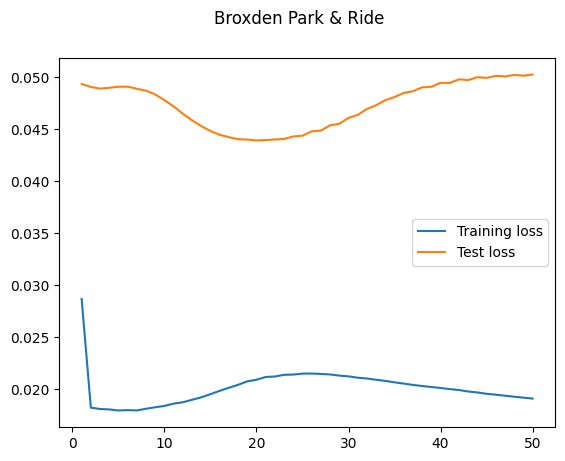

Broxden Park & Ride Root Mean Squared Error (RMSE): 86.0211369062425

 Crown Inn Wynd Car Park, Auchterarder 

(1389, 30, 1) (1389, 1) (10, 30, 1) (10, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0149, Test Loss: 0.0106
Epoch [20/50] - Training Loss: 0.0155, Test Loss: 0.0106
Epoch [30/50] - Training Loss: 0.0155, Test Loss: 0.0106
Epoch [40/50] - Training Loss: 0.0153, Test Loss: 0.0105
Epoch [50/50] - Training Loss: 0.0149, Test Loss: 0.0103


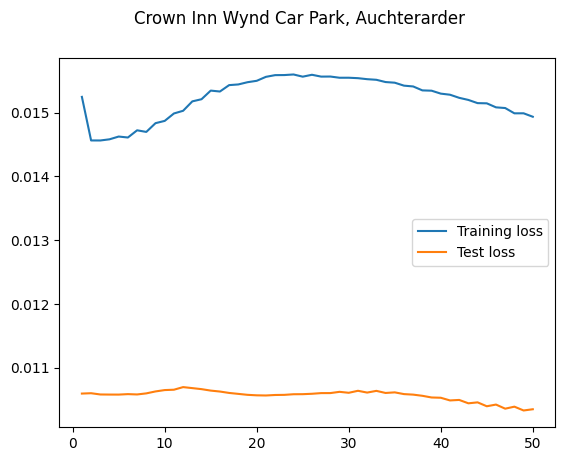

Crown Inn Wynd Car Park, Auchterarder Root Mean Squared Error (RMSE): 20.33540083625505

 South Inch Car Park 

(1390, 30, 1) (1390, 1) (10, 30, 1) (10, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0123, Test Loss: 0.0131
Epoch [20/50] - Training Loss: 0.0129, Test Loss: 0.0139
Epoch [30/50] - Training Loss: 0.0136, Test Loss: 0.0135
Epoch [40/50] - Training Loss: 0.0136, Test Loss: 0.0134
Epoch [50/50] - Training Loss: 0.0135, Test Loss: 0.0134


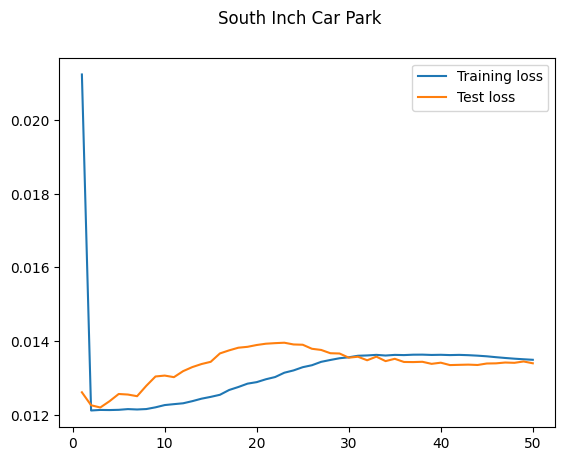

South Inch Car Park Root Mean Squared Error (RMSE): 31.845223347716804

 Kinross Park and Ride 

(1390, 30, 1) (1390, 1) (10, 30, 1) (10, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0250, Test Loss: 0.0227
Epoch [20/50] - Training Loss: 0.0180, Test Loss: 0.0227
Epoch [30/50] - Training Loss: 0.0166, Test Loss: 0.0229
Epoch [40/50] - Training Loss: 0.0163, Test Loss: 0.0227
Epoch [50/50] - Training Loss: 0.0160, Test Loss: 0.0226


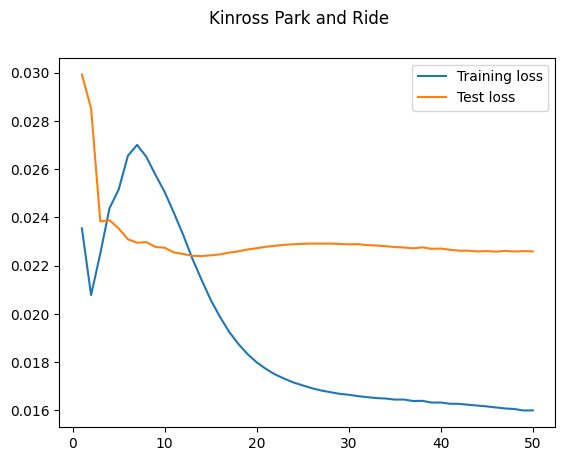

Kinross Park and Ride Root Mean Squared Error (RMSE): 57.78525337978093

 Leslie Street Car Park, Blairgowrie 

(1390, 30, 1) (1390, 1) (10, 30, 1) (10, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0142, Test Loss: 0.0226
Epoch [20/50] - Training Loss: 0.0142, Test Loss: 0.0229
Epoch [30/50] - Training Loss: 0.0143, Test Loss: 0.0234
Epoch [40/50] - Training Loss: 0.0144, Test Loss: 0.0239
Epoch [50/50] - Training Loss: 0.0145, Test Loss: 0.0242


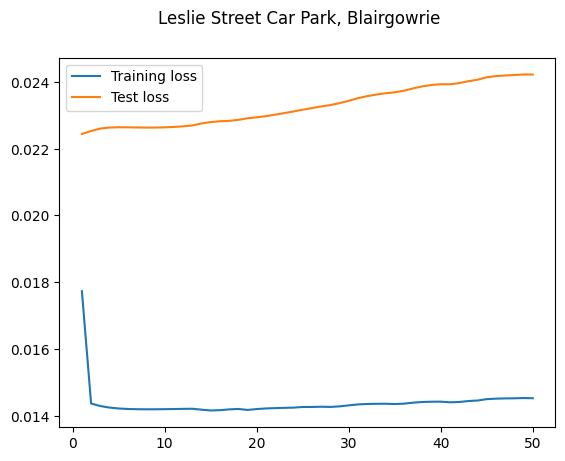

Leslie Street Car Park, Blairgowrie Root Mean Squared Error (RMSE): 27.392240927819262

 Canal Street Car Park 

(1043, 30, 1) (1043, 1) (10, 30, 1) (10, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0341, Test Loss: 0.0225
Epoch [20/50] - Training Loss: 0.0338, Test Loss: 0.0204
Epoch [30/50] - Training Loss: 0.0335, Test Loss: 0.0201
Epoch [40/50] - Training Loss: 0.0332, Test Loss: 0.0193
Epoch [50/50] - Training Loss: 0.0329, Test Loss: 0.0189


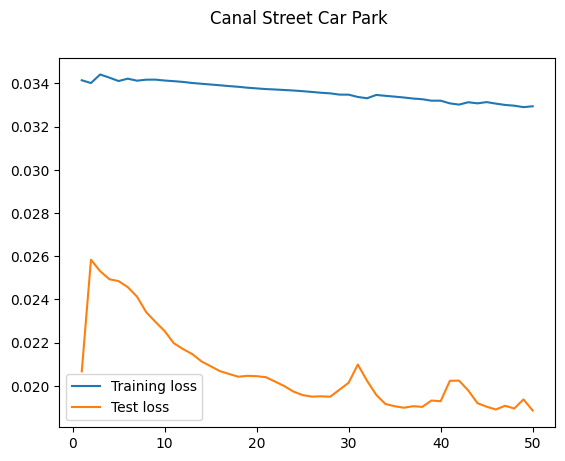

Canal Street Car Park Root Mean Squared Error (RMSE): 12.767522118871852

 King Street Car Park 

(1389, 30, 1) (1389, 1) (10, 30, 1) (10, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0187, Test Loss: 0.0139
Epoch [20/50] - Training Loss: 0.0187, Test Loss: 0.0140
Epoch [30/50] - Training Loss: 0.0187, Test Loss: 0.0144
Epoch [40/50] - Training Loss: 0.0186, Test Loss: 0.0145
Epoch [50/50] - Training Loss: 0.0186, Test Loss: 0.0147


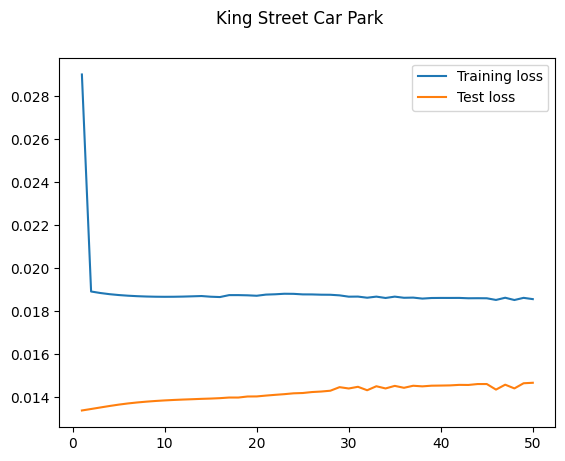

King Street Car Park Root Mean Squared Error (RMSE): 29.195587851790975

 Moness Terrace Car Park, Aberfeldy 

(1389, 30, 1) (1389, 1) (10, 30, 1) (10, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0227, Test Loss: 0.0674
Epoch [20/50] - Training Loss: 0.0224, Test Loss: 0.0687
Epoch [30/50] - Training Loss: 0.0220, Test Loss: 0.0660
Epoch [40/50] - Training Loss: 0.0215, Test Loss: 0.0677
Epoch [50/50] - Training Loss: 0.0210, Test Loss: 0.0675


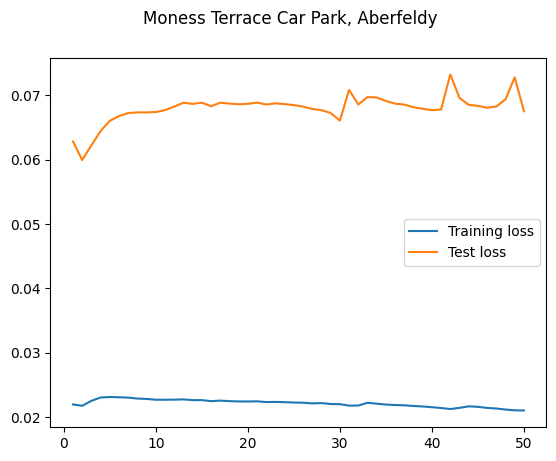

Moness Terrace Car Park, Aberfeldy Root Mean Squared Error (RMSE): 40.69699218161686

 Atholl Street Car Park, Dunkeld 

(1026, 30, 1) (1026, 1) (10, 30, 1) (10, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0048, Test Loss: 0.0042
Epoch [20/50] - Training Loss: 0.0049, Test Loss: 0.0044
Epoch [30/50] - Training Loss: 0.0050, Test Loss: 0.0042
Epoch [40/50] - Training Loss: 0.0049, Test Loss: 0.0040
Epoch [50/50] - Training Loss: 0.0049, Test Loss: 0.0040


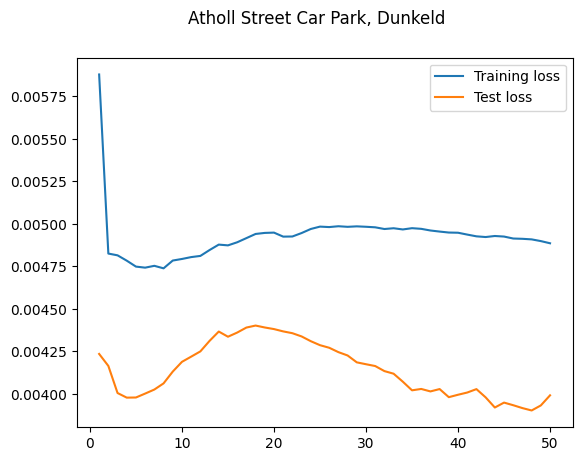

Atholl Street Car Park, Dunkeld Root Mean Squared Error (RMSE): 21.500072030922542

 Rie-Achan Road Car Park, Pitlochry 

(1390, 30, 1) (1390, 1) (10, 30, 1) (10, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0091, Test Loss: 0.0118
Epoch [20/50] - Training Loss: 0.0092, Test Loss: 0.0116
Epoch [30/50] - Training Loss: 0.0090, Test Loss: 0.0113
Epoch [40/50] - Training Loss: 0.0090, Test Loss: 0.0113
Epoch [50/50] - Training Loss: 0.0089, Test Loss: 0.0112


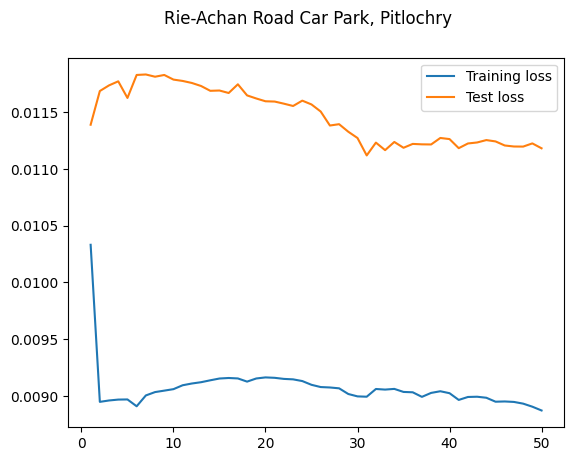

Rie-Achan Road Car Park, Pitlochry Root Mean Squared Error (RMSE): 40.17110184672316

 Friarton Depot 

(1390, 30, 1) (1390, 1) (10, 30, 1) (10, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50] - Training Loss: 0.0118, Test Loss: 0.0228
Epoch [20/50] - Training Loss: 0.0117, Test Loss: 0.0228
Epoch [30/50] - Training Loss: 0.0116, Test Loss: 0.0233
Epoch [40/50] - Training Loss: 0.0115, Test Loss: 0.0234
Epoch [50/50] - Training Loss: 0.0115, Test Loss: 0.0234


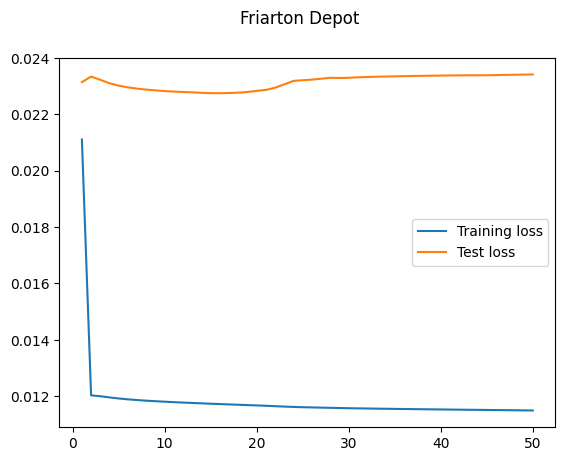

Friarton Depot Root Mean Squared Error (RMSE): 17.45794452214071


In [109]:
train_lstm(df_dict=stations_dict, type='daily', sequence_length=30, stations=stations, 
           num_epochs=50, predictions_dict=daily_predictions_dict, test_obs=10)

In [110]:
# File path to save the dictionary
file_path = 'daily_predictions_perth.pkl'

# Save the dictionary to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(daily_predictions_dict, file)

print(f"Dictionary saved to '{file_path}'")

Dictionary saved to 'daily_predictions_perth.pkl'


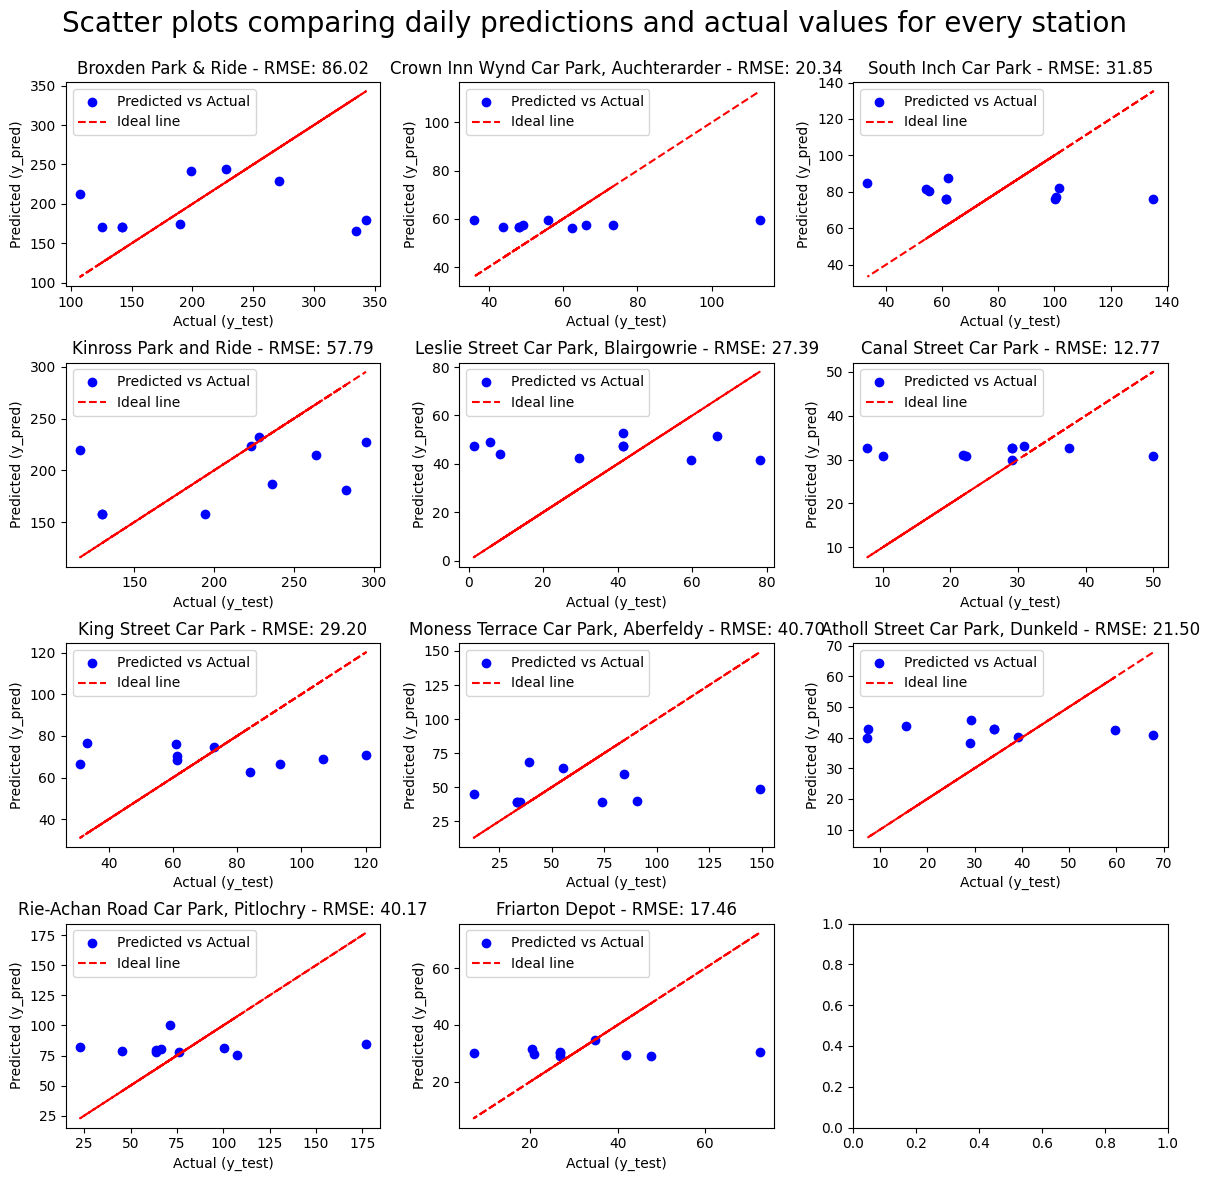

In [111]:
# Define the number of rows and columns for subplots
n_rows = 4
n_cols = 3

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(daily_predictions_dict.keys()):
    # Get data for the current station
    station_data = daily_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot y_pred against y_test
    axs[i].scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
    axs[i].plot(y_test, y_test, color='red', linestyle='--', label='Ideal line')

    axs[i].set_title(f'{station} - RMSE: {rmse:.2f}')
    axs[i].set_xlabel('Actual (y_test)')
    axs[i].set_ylabel('Predicted (y_pred)')
    axs[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Scatter plots comparing daily predictions and actual values for every station', fontsize=20)
plt.show()

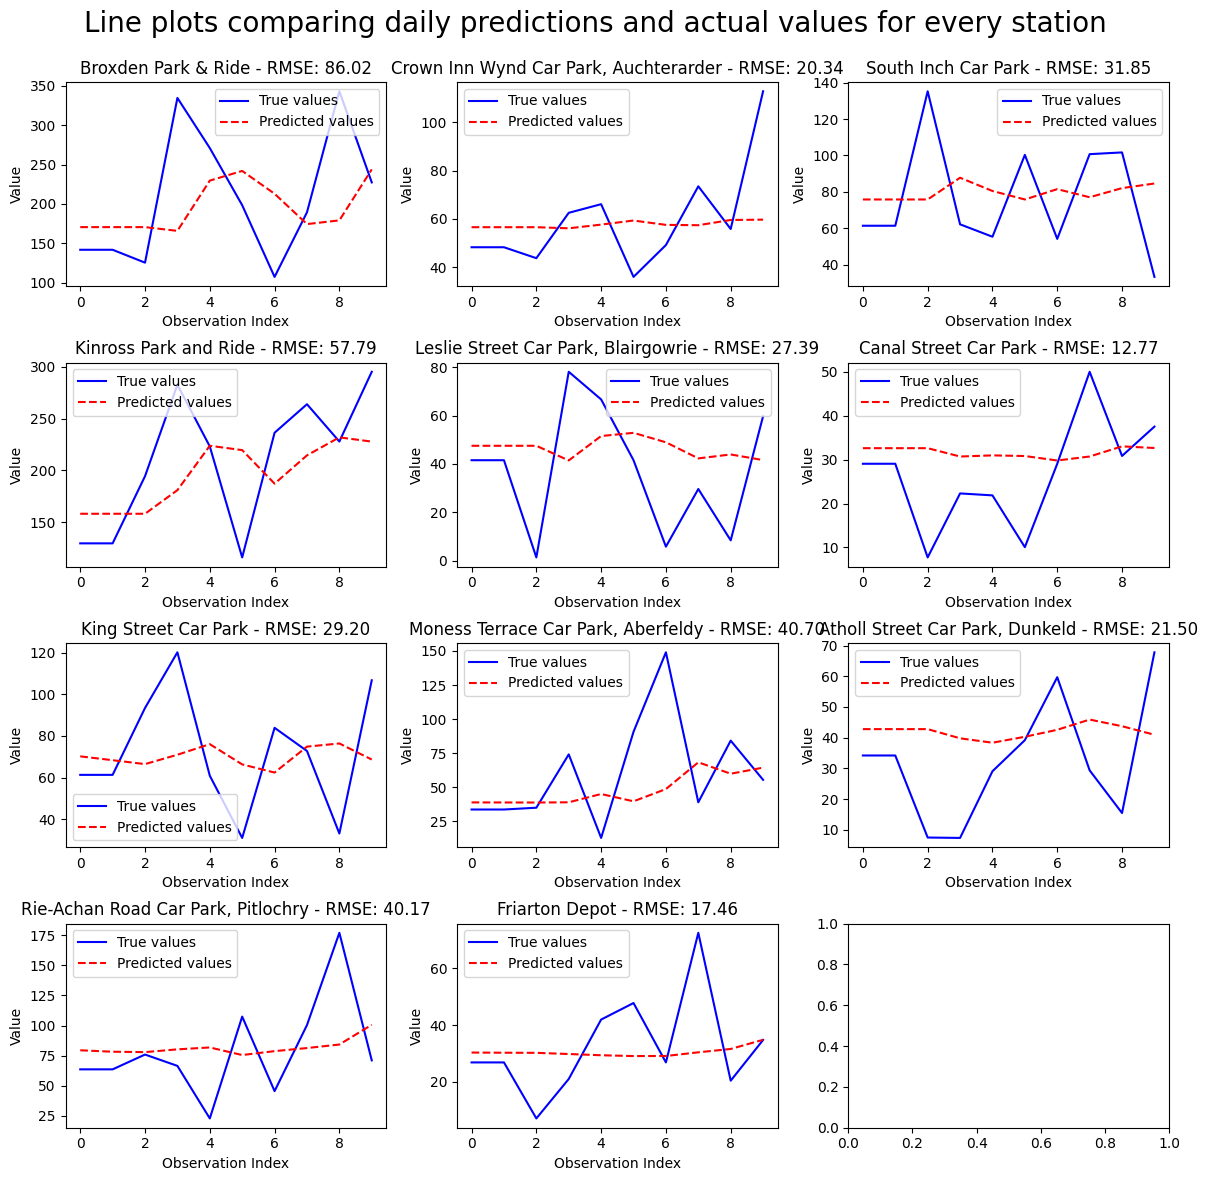

In [112]:
# Define the number of rows and columns for subplots
n_rows = 4
n_cols = 3

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(daily_predictions_dict.keys()):
    # Get data for the current station
    station_data = daily_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot true values and predicted values against the index of observations
    x = np.arange(len(y_test))
    axs[i].plot(x, y_test, color='blue', label='True values')
    axs[i].plot(x, y_pred, color='red', linestyle='--', label='Predicted values')

    axs[i].set_title(f'{station} - RMSE: {rmse:.2f}')
    axs[i].set_xlabel('Observation Index')
    axs[i].set_ylabel('Value')
    axs[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Line plots comparing daily predictions and actual values for every station', fontsize=20)
plt.show()

The results are rather poor. This is the result of multitude of missing observations. The predictions are almost flat and do not account for changes between the steps. Definately predictions like this are of little use. 

### 3.2 Weekly Model Implementation

Weekly model is trained to predict also based on 30 previous observations. Test set contains last 12 observations (rest is used for training). This time the model is trained twice as long as the convergence has not been reached within 50 epochs. The training output has been colapsed as it used only for diagnostics. Results are shown at the end.

In [114]:
# Initialize dict for storing predictions
weekly_predictions_dict = {}
for station in stations:
    weekly_predictions_dict[station] = {'y_test':[], 'y_pred':[], 'rmse':0}


 Broxden Park & Ride 

(163, 30, 1) (163, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0311, Test Loss: 0.0322
Epoch [20/100] - Training Loss: 0.0234, Test Loss: 0.0477
Epoch [30/100] - Training Loss: 0.0223, Test Loss: 0.0433
Epoch [40/100] - Training Loss: 0.0219, Test Loss: 0.0429
Epoch [50/100] - Training Loss: 0.0216, Test Loss: 0.0427
Epoch [60/100] - Training Loss: 0.0213, Test Loss: 0.0426
Epoch [70/100] - Training Loss: 0.0211, Test Loss: 0.0422
Epoch [80/100] - Training Loss: 0.0209, Test Loss: 0.0420
Epoch [90/100] - Training Loss: 0.0207, Test Loss: 0.0420
Epoch [100/100] - Training Loss: 0.0210, Test Loss: 0.0445


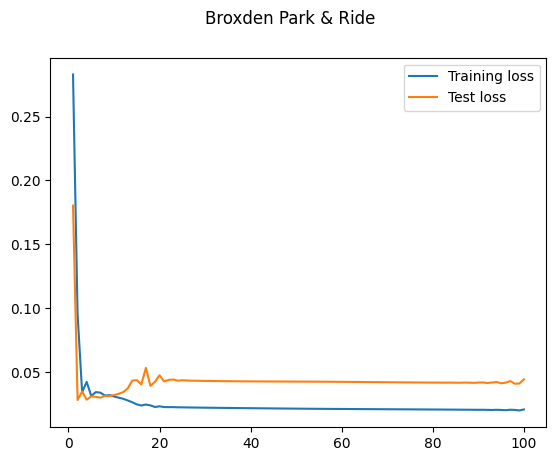

Broxden Park & Ride Root Mean Squared Error (RMSE): 374.0000242099672

 Crown Inn Wynd Car Park, Auchterarder 

(163, 30, 1) (163, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0373, Test Loss: 0.0281
Epoch [20/100] - Training Loss: 0.0338, Test Loss: 0.0311
Epoch [30/100] - Training Loss: 0.0315, Test Loss: 0.0345
Epoch [40/100] - Training Loss: 0.0313, Test Loss: 0.0339
Epoch [50/100] - Training Loss: 0.0312, Test Loss: 0.0334
Epoch [60/100] - Training Loss: 0.0311, Test Loss: 0.0331
Epoch [70/100] - Training Loss: 0.0310, Test Loss: 0.0329
Epoch [80/100] - Training Loss: 0.0310, Test Loss: 0.0327
Epoch [90/100] - Training Loss: 0.0309, Test Loss: 0.0326
Epoch [100/100] - Training Loss: 0.0309, Test Loss: 0.0325


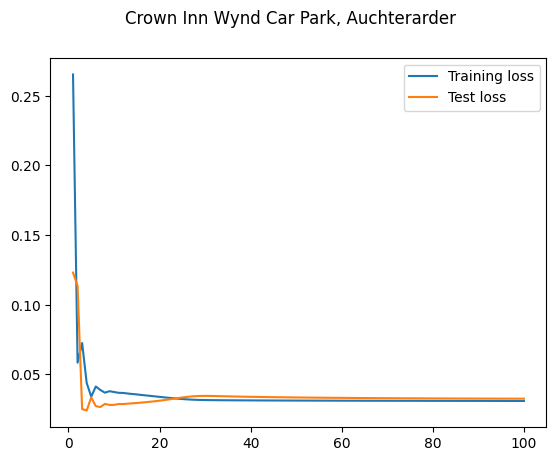

Crown Inn Wynd Car Park, Auchterarder Root Mean Squared Error (RMSE): 111.68140434929623

 South Inch Car Park 

(163, 30, 1) (163, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0343, Test Loss: 0.0279
Epoch [20/100] - Training Loss: 0.0300, Test Loss: 0.0341
Epoch [30/100] - Training Loss: 0.0260, Test Loss: 0.0537
Epoch [40/100] - Training Loss: 0.0251, Test Loss: 0.0527
Epoch [50/100] - Training Loss: 0.0247, Test Loss: 0.0498
Epoch [60/100] - Training Loss: 0.0246, Test Loss: 0.0485
Epoch [70/100] - Training Loss: 0.0245, Test Loss: 0.0477
Epoch [80/100] - Training Loss: 0.0244, Test Loss: 0.0467
Epoch [90/100] - Training Loss: 0.0242, Test Loss: 0.0452
Epoch [100/100] - Training Loss: 0.0240, Test Loss: 0.0432


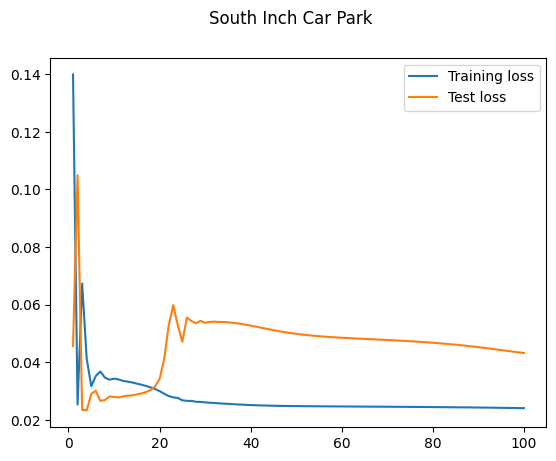

South Inch Car Park Root Mean Squared Error (RMSE): 169.40939108459844

 Kinross Park and Ride 

(163, 30, 1) (163, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0294, Test Loss: 0.0563
Epoch [20/100] - Training Loss: 0.0235, Test Loss: 0.0592
Epoch [30/100] - Training Loss: 0.0226, Test Loss: 0.0565
Epoch [40/100] - Training Loss: 0.0222, Test Loss: 0.0547
Epoch [50/100] - Training Loss: 0.0219, Test Loss: 0.0547
Epoch [60/100] - Training Loss: 0.0219, Test Loss: 0.0560
Epoch [70/100] - Training Loss: 0.0217, Test Loss: 0.0575
Epoch [80/100] - Training Loss: 0.0216, Test Loss: 0.0593
Epoch [90/100] - Training Loss: 0.0213, Test Loss: 0.0624
Epoch [100/100] - Training Loss: 0.0209, Test Loss: 0.0705


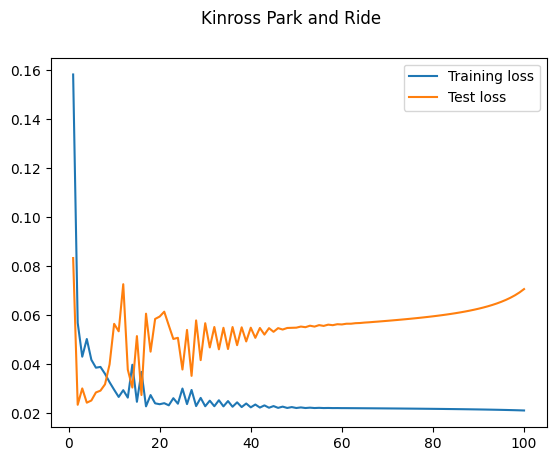

Kinross Park and Ride Root Mean Squared Error (RMSE): 516.7567610041855

 Leslie Street Car Park, Blairgowrie 

(163, 30, 1) (163, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0355, Test Loss: 0.0281
Epoch [20/100] - Training Loss: 0.0316, Test Loss: 0.0302
Epoch [30/100] - Training Loss: 0.0303, Test Loss: 0.0285
Epoch [40/100] - Training Loss: 0.0300, Test Loss: 0.0279
Epoch [50/100] - Training Loss: 0.0299, Test Loss: 0.0276
Epoch [60/100] - Training Loss: 0.0298, Test Loss: 0.0274
Epoch [70/100] - Training Loss: 0.0298, Test Loss: 0.0273
Epoch [80/100] - Training Loss: 0.0297, Test Loss: 0.0272
Epoch [90/100] - Training Loss: 0.0297, Test Loss: 0.0271
Epoch [100/100] - Training Loss: 0.0296, Test Loss: 0.0272


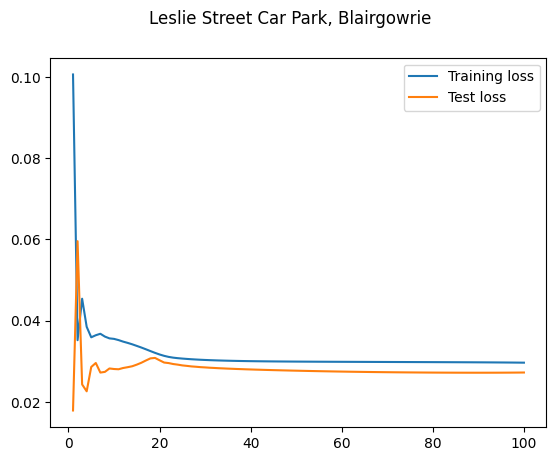

Leslie Street Car Park, Blairgowrie Root Mean Squared Error (RMSE): 90.36708732870461

 Canal Street Car Park 

(113, 30, 1) (113, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0335, Test Loss: 0.0494
Epoch [20/100] - Training Loss: 0.0337, Test Loss: 0.0485
Epoch [30/100] - Training Loss: 0.0336, Test Loss: 0.0487
Epoch [40/100] - Training Loss: 0.0334, Test Loss: 0.0488
Epoch [50/100] - Training Loss: 0.0332, Test Loss: 0.0490
Epoch [60/100] - Training Loss: 0.0331, Test Loss: 0.0492
Epoch [70/100] - Training Loss: 0.0329, Test Loss: 0.0495
Epoch [80/100] - Training Loss: 0.0327, Test Loss: 0.0501
Epoch [90/100] - Training Loss: 0.0325, Test Loss: 0.0510
Epoch [100/100] - Training Loss: 0.0322, Test Loss: 0.0519


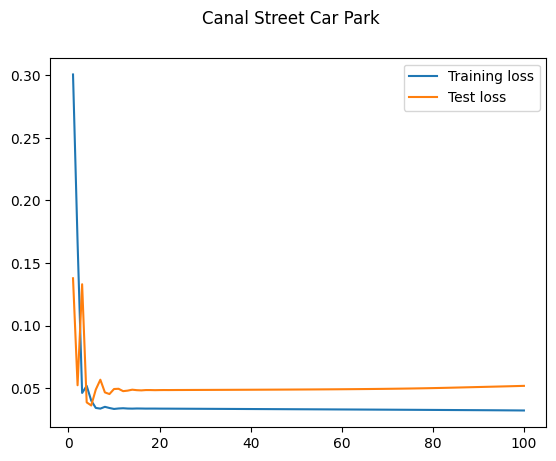

Canal Street Car Park Root Mean Squared Error (RMSE): 78.42366847474305

 King Street Car Park 

(163, 30, 1) (163, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0407, Test Loss: 0.0434
Epoch [20/100] - Training Loss: 0.0372, Test Loss: 0.0480
Epoch [30/100] - Training Loss: 0.0327, Test Loss: 0.0510
Epoch [40/100] - Training Loss: 0.0321, Test Loss: 0.0509
Epoch [50/100] - Training Loss: 0.0317, Test Loss: 0.0512
Epoch [60/100] - Training Loss: 0.0314, Test Loss: 0.0516
Epoch [70/100] - Training Loss: 0.0313, Test Loss: 0.0520
Epoch [80/100] - Training Loss: 0.0311, Test Loss: 0.0523
Epoch [90/100] - Training Loss: 0.0310, Test Loss: 0.0526
Epoch [100/100] - Training Loss: 0.0309, Test Loss: 0.0529


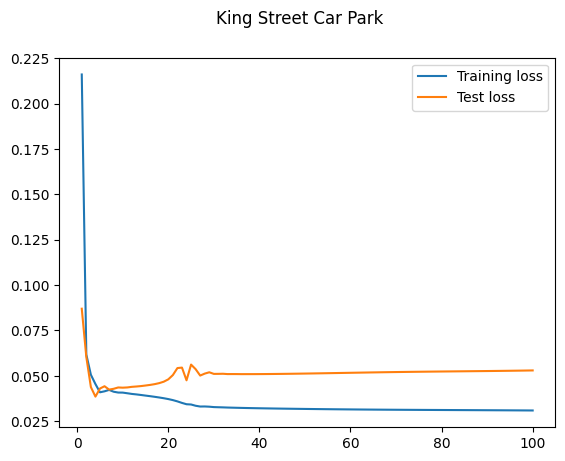

King Street Car Park Root Mean Squared Error (RMSE): 171.5478494015443

 Moness Terrace Car Park, Aberfeldy 

(163, 30, 1) (163, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0360, Test Loss: 0.0468
Epoch [20/100] - Training Loss: 0.0294, Test Loss: 0.0582
Epoch [30/100] - Training Loss: 0.0277, Test Loss: 0.0801
Epoch [40/100] - Training Loss: 0.0273, Test Loss: 0.0790
Epoch [50/100] - Training Loss: 0.0268, Test Loss: 0.0802
Epoch [60/100] - Training Loss: 0.0266, Test Loss: 0.0779
Epoch [70/100] - Training Loss: 0.0266, Test Loss: 0.0772
Epoch [80/100] - Training Loss: 0.0265, Test Loss: 0.0733
Epoch [90/100] - Training Loss: 0.0261, Test Loss: 0.0586
Epoch [100/100] - Training Loss: 0.0271, Test Loss: 0.0662


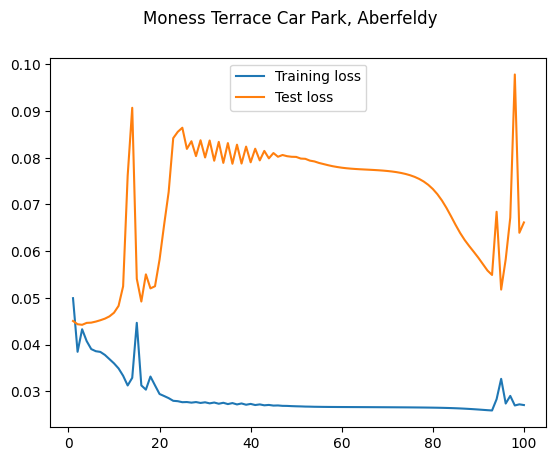

Moness Terrace Car Park, Aberfeldy Root Mean Squared Error (RMSE): 138.55428549705707

 Atholl Street Car Park, Dunkeld 

(111, 30, 1) (111, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0375, Test Loss: 0.0515
Epoch [20/100] - Training Loss: 0.0316, Test Loss: 0.0573
Epoch [30/100] - Training Loss: 0.0309, Test Loss: 0.0571
Epoch [40/100] - Training Loss: 0.0304, Test Loss: 0.0573
Epoch [50/100] - Training Loss: 0.0299, Test Loss: 0.0583
Epoch [60/100] - Training Loss: 0.0295, Test Loss: 0.0581
Epoch [70/100] - Training Loss: 0.0292, Test Loss: 0.0585
Epoch [80/100] - Training Loss: 0.0291, Test Loss: 0.0585
Epoch [90/100] - Training Loss: 0.0287, Test Loss: 0.0589
Epoch [100/100] - Training Loss: 0.0285, Test Loss: 0.0570


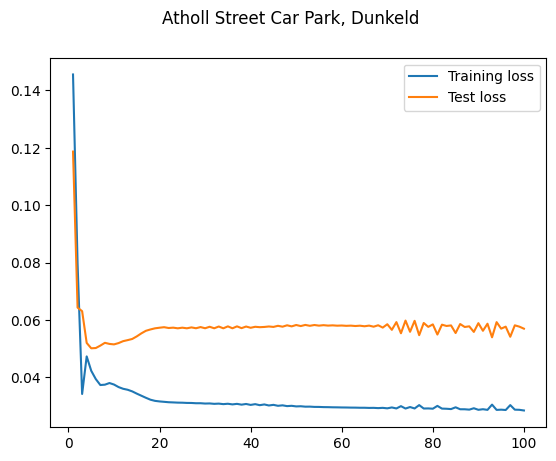

Atholl Street Car Park, Dunkeld Root Mean Squared Error (RMSE): 138.53639750667725

 Rie-Achan Road Car Park, Pitlochry 

(163, 30, 1) (163, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0226, Test Loss: 0.0144
Epoch [20/100] - Training Loss: 0.0193, Test Loss: 0.0351
Epoch [30/100] - Training Loss: 0.0185, Test Loss: 0.0301
Epoch [40/100] - Training Loss: 0.0186, Test Loss: 0.0273
Epoch [50/100] - Training Loss: 0.0183, Test Loss: 0.0273
Epoch [60/100] - Training Loss: 0.0182, Test Loss: 0.0269
Epoch [70/100] - Training Loss: 0.0183, Test Loss: 0.0277
Epoch [80/100] - Training Loss: 0.0181, Test Loss: 0.0290
Epoch [90/100] - Training Loss: 0.0179, Test Loss: 0.0264
Epoch [100/100] - Training Loss: 0.0178, Test Loss: 0.0209


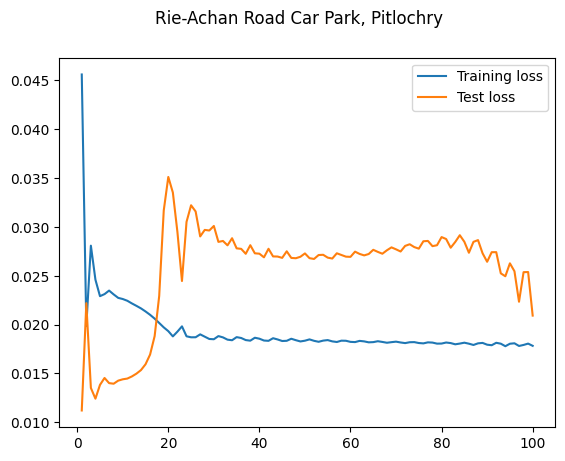

Rie-Achan Road Car Park, Pitlochry Root Mean Squared Error (RMSE): 161.47701771623798

 Friarton Depot 

(163, 30, 1) (163, 1) (12, 30, 1) (12, 1)


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/100] - Training Loss: 0.0278, Test Loss: 0.0311
Epoch [20/100] - Training Loss: 0.0277, Test Loss: 0.0313
Epoch [30/100] - Training Loss: 0.0277, Test Loss: 0.0313
Epoch [40/100] - Training Loss: 0.0277, Test Loss: 0.0313
Epoch [50/100] - Training Loss: 0.0276, Test Loss: 0.0313
Epoch [60/100] - Training Loss: 0.0276, Test Loss: 0.0313
Epoch [70/100] - Training Loss: 0.0274, Test Loss: 0.0313
Epoch [80/100] - Training Loss: 0.0271, Test Loss: 0.0314
Epoch [90/100] - Training Loss: 0.0268, Test Loss: 0.0319
Epoch [100/100] - Training Loss: 0.0265, Test Loss: 0.0326


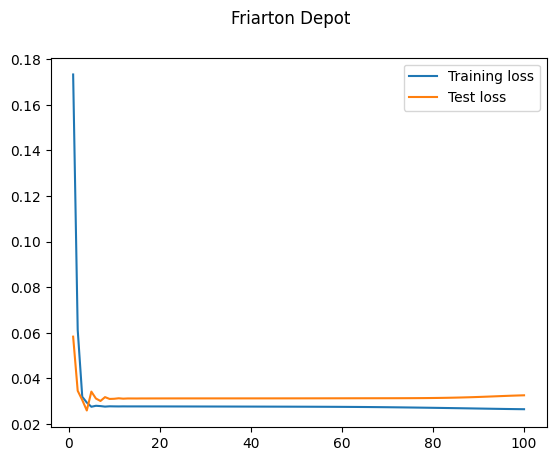

Friarton Depot Root Mean Squared Error (RMSE): 56.16561676090191


In [115]:
train_lstm(df_dict=stations_dict, type='weekly', sequence_length=30, stations=stations, 
           num_epochs=100, predictions_dict=weekly_predictions_dict, test_obs=12)

In [116]:
# File path to save the dictionary
file_path = 'weekly_predictions_perth.pkl'

# Save the dictionary to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(weekly_predictions_dict, file)

print(f"Dictionary saved to '{file_path}'")

Dictionary saved to 'weekly_predictions_perth.pkl'


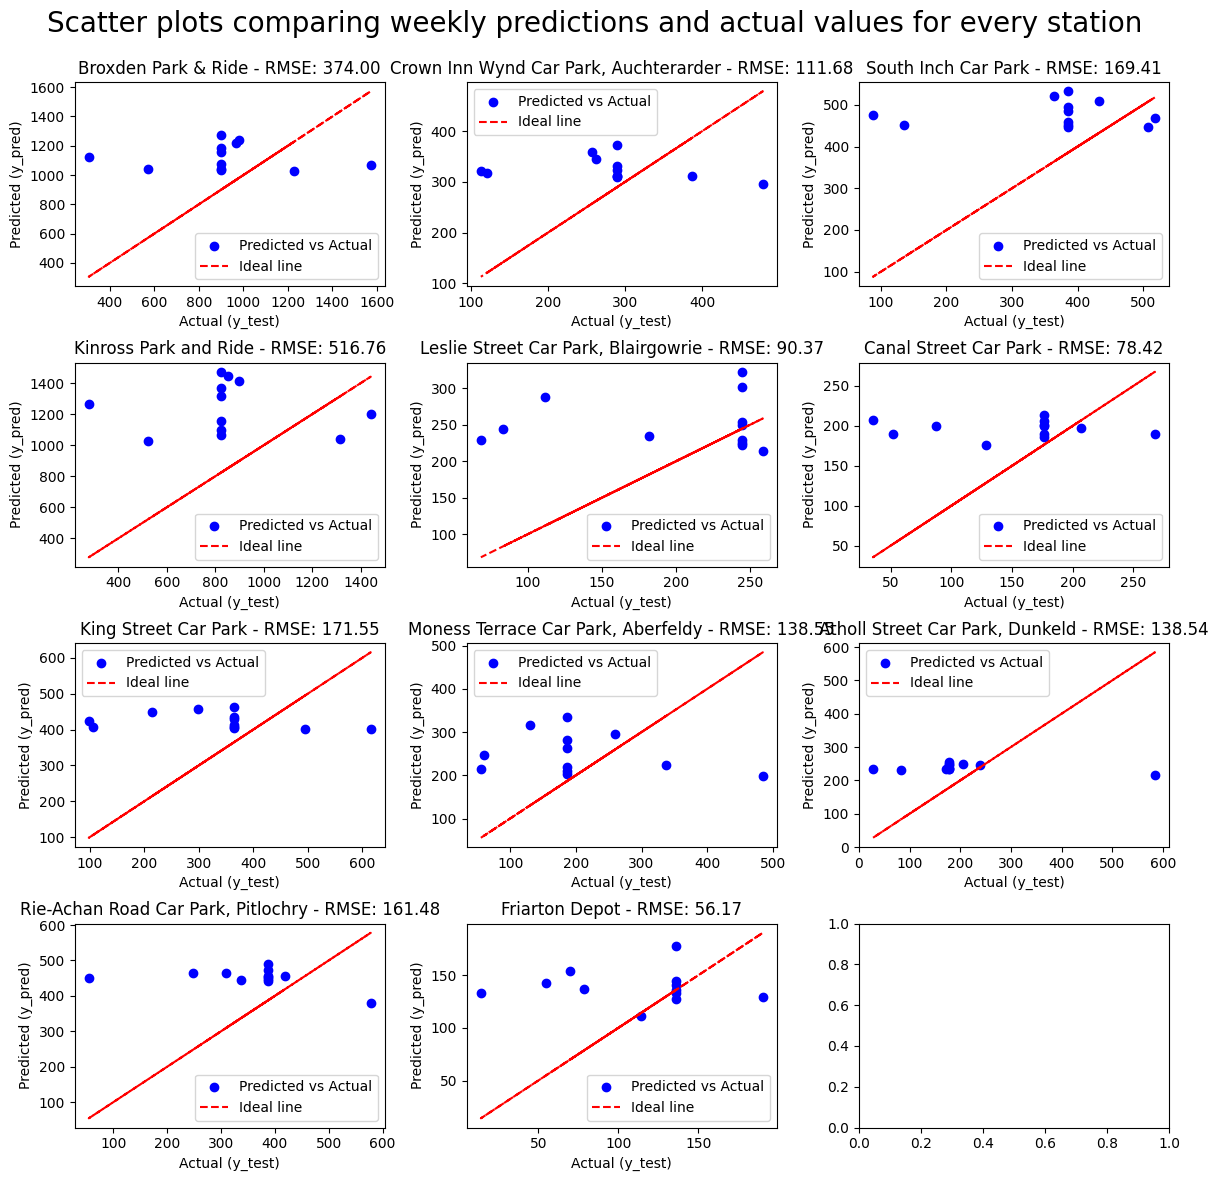

In [122]:
# Define the number of rows and columns for subplots
n_rows = 4
n_cols = 3

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(weekly_predictions_dict.keys()):
    # Get data for the current station
    station_data = weekly_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot y_pred against y_test
    axs[i].scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
    axs[i].plot(y_test, y_test, color='red', linestyle='--', label='Ideal line')

    axs[i].set_title(f'{station} - RMSE: {rmse:.2f}')
    axs[i].set_xlabel('Actual (y_test)')
    axs[i].set_ylabel('Predicted (y_pred)')
    axs[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Scatter plots comparing weekly predictions and actual values for every station', fontsize=20)
plt.show()

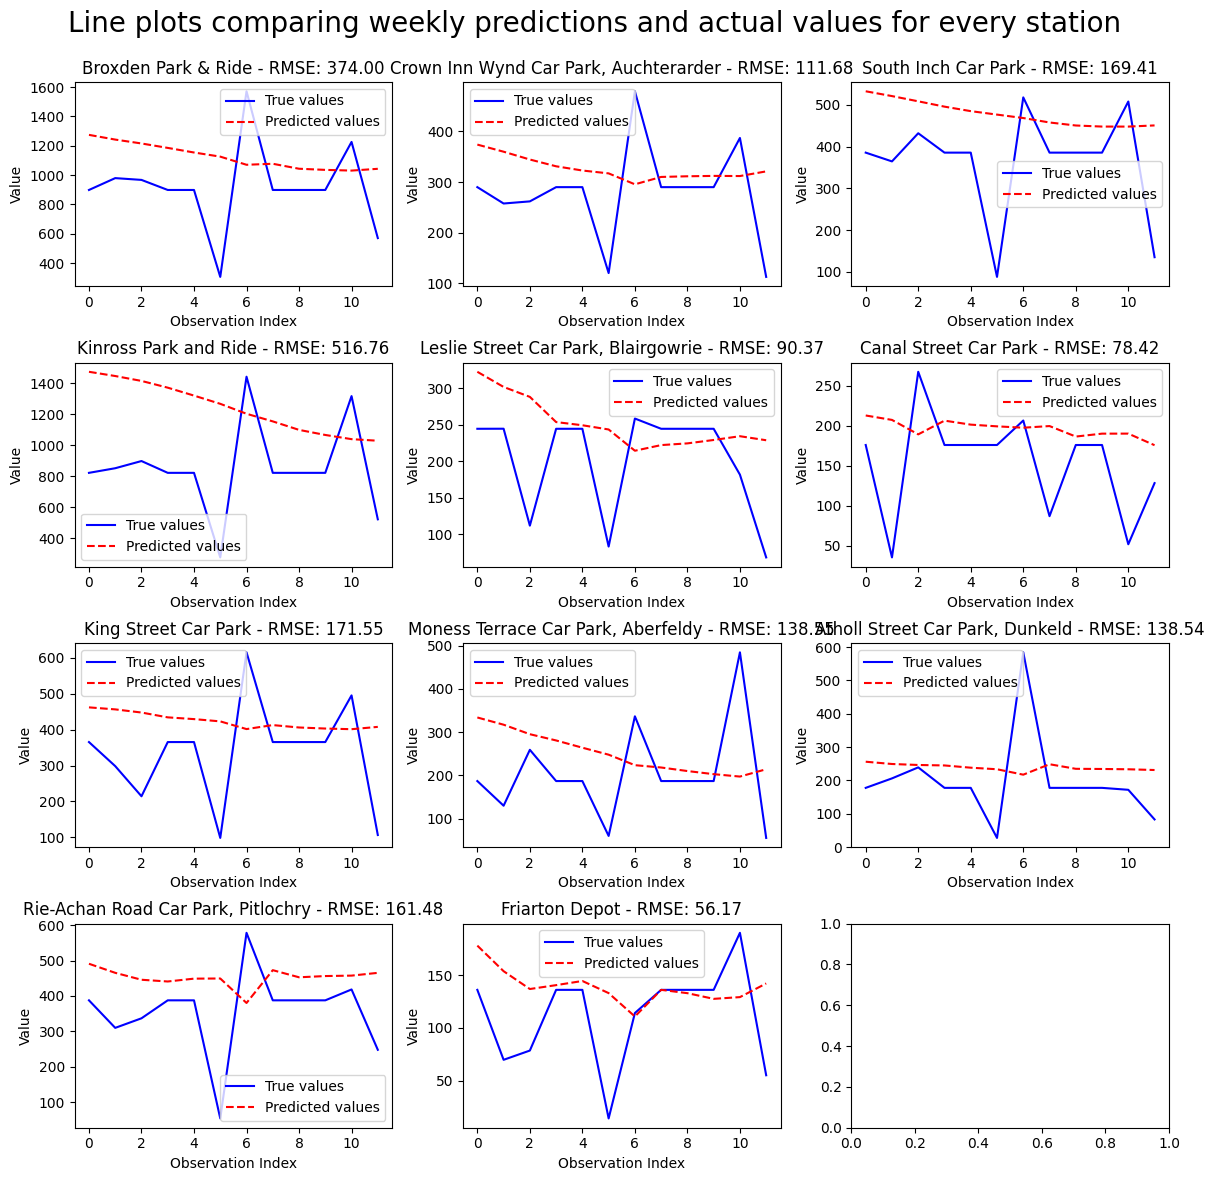

In [123]:
# Define the number of rows and columns for subplots
n_rows = 4
n_cols = 3

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(weekly_predictions_dict.keys()):
    # Get data for the current station
    station_data = weekly_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot true values and predicted values against the index of observations
    x = np.arange(len(y_test))
    axs[i].plot(x, y_test, color='blue', label='True values')
    axs[i].plot(x, y_pred, color='red', linestyle='--', label='Predicted values')

    axs[i].set_title(f'{station} - RMSE: {rmse:.2f}')
    axs[i].set_xlabel('Observation Index')
    axs[i].set_ylabel('Value')
    axs[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Line plots comparing weekly predictions and actual values for every station', fontsize=20)
plt.show()


The results are again very dissapointing. Predictions are basically straight lines which compared to the baseline model should not be much better.

### 3.3 Monthly Model Implementation

Monthly model is trained to predict also based on only 6 previous observations due to time-range. Test set contains last 6 observations (rest is used for training). This time the model is trained even longer to achieve convergence - 300 epochs. The training output has been colapsed as it used only for diagnostics. Results are shown at the end.

In [125]:
# Initialize dict for storing predictions
monthly_predictions_dict = {}
for station in stations:
    monthly_predictions_dict[station] = {'y_test':[], 'y_pred':[], 'rmse':0}


 Broxden Park & Ride 

(36, 6, 1) (36, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0300, Test Loss: 0.1732


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/300] - Training Loss: 0.0271, Test Loss: 0.1264
Epoch [30/300] - Training Loss: 0.0196, Test Loss: 0.1377
Epoch [40/300] - Training Loss: 0.0130, Test Loss: 0.1512
Epoch [50/300] - Training Loss: 0.0105, Test Loss: 0.1581
Epoch [60/300] - Training Loss: 0.0103, Test Loss: 0.1589
Epoch [70/300] - Training Loss: 0.0101, Test Loss: 0.1585
Epoch [80/300] - Training Loss: 0.0100, Test Loss: 0.1581
Epoch [90/300] - Training Loss: 0.0098, Test Loss: 0.1578
Epoch [100/300] - Training Loss: 0.0097, Test Loss: 0.1575
Epoch [110/300] - Training Loss: 0.0096, Test Loss: 0.1572
Epoch [120/300] - Training Loss: 0.0095, Test Loss: 0.1568
Epoch [130/300] - Training Loss: 0.0094, Test Loss: 0.1565
Epoch [140/300] - Training Loss: 0.0093, Test Loss: 0.1561
Epoch [150/300] - Training Loss: 0.0092, Test Loss: 0.1558
Epoch [160/300] - Training Loss: 0.0091, Test Loss: 0.1554
Epoch [170/300] - Training Loss: 0.0090, Test Loss: 0.1551
Epoch [180/300] - Training Loss: 0.0090, Test Loss: 0.1547
Epoch

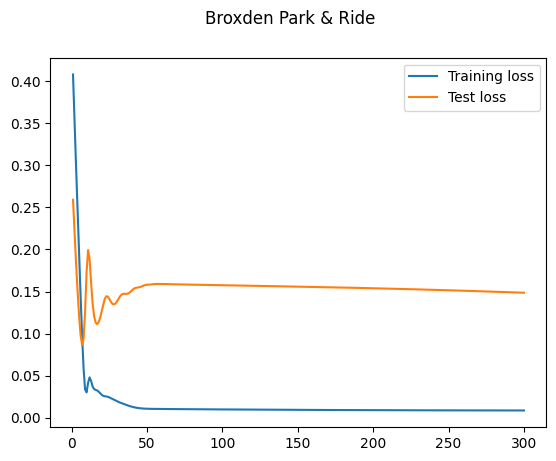

Broxden Park & Ride Root Mean Squared Error (RMSE): 2275.774121576834

 Crown Inn Wynd Car Park, Auchterarder 

(36, 6, 1) (36, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0422, Test Loss: 0.1540


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/300] - Training Loss: 0.0393, Test Loss: 0.1229
Epoch [30/300] - Training Loss: 0.0312, Test Loss: 0.1394
Epoch [40/300] - Training Loss: 0.0268, Test Loss: 0.1514
Epoch [50/300] - Training Loss: 0.0255, Test Loss: 0.1529
Epoch [60/300] - Training Loss: 0.0247, Test Loss: 0.1515
Epoch [70/300] - Training Loss: 0.0239, Test Loss: 0.1498
Epoch [80/300] - Training Loss: 0.0231, Test Loss: 0.1480
Epoch [90/300] - Training Loss: 0.0222, Test Loss: 0.1459
Epoch [100/300] - Training Loss: 0.0213, Test Loss: 0.1434
Epoch [110/300] - Training Loss: 0.0204, Test Loss: 0.1406
Epoch [120/300] - Training Loss: 0.0195, Test Loss: 0.1372
Epoch [130/300] - Training Loss: 0.0186, Test Loss: 0.1333
Epoch [140/300] - Training Loss: 0.0178, Test Loss: 0.1287
Epoch [150/300] - Training Loss: 0.0170, Test Loss: 0.1236
Epoch [160/300] - Training Loss: 0.0163, Test Loss: 0.1183
Epoch [170/300] - Training Loss: 0.0157, Test Loss: 0.1132
Epoch [180/300] - Training Loss: 0.0151, Test Loss: 0.1085
Epoch

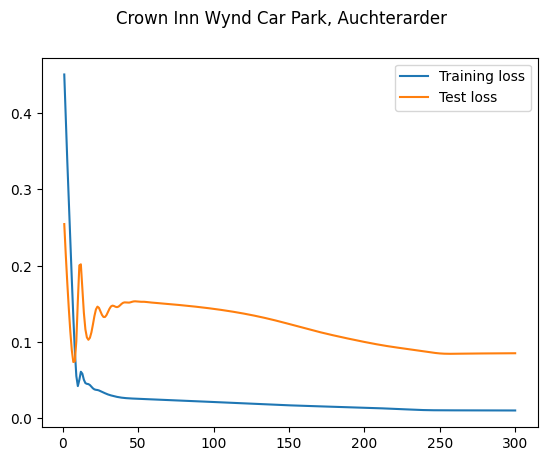

Crown Inn Wynd Car Park, Auchterarder Root Mean Squared Error (RMSE): 587.4572436661911

 South Inch Car Park 

(36, 6, 1) (36, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0419, Test Loss: 0.1546


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/300] - Training Loss: 0.0254, Test Loss: 0.1722
Epoch [30/300] - Training Loss: 0.0193, Test Loss: 0.1986
Epoch [40/300] - Training Loss: 0.0145, Test Loss: 0.2235
Epoch [50/300] - Training Loss: 0.0112, Test Loss: 0.2483
Epoch [60/300] - Training Loss: 0.0097, Test Loss: 0.2699
Epoch [70/300] - Training Loss: 0.0094, Test Loss: 0.2814
Epoch [80/300] - Training Loss: 0.0094, Test Loss: 0.2829
Epoch [90/300] - Training Loss: 0.0094, Test Loss: 0.2819
Epoch [100/300] - Training Loss: 0.0094, Test Loss: 0.2809
Epoch [110/300] - Training Loss: 0.0093, Test Loss: 0.2800
Epoch [120/300] - Training Loss: 0.0093, Test Loss: 0.2791
Epoch [130/300] - Training Loss: 0.0093, Test Loss: 0.2782
Epoch [140/300] - Training Loss: 0.0093, Test Loss: 0.2773
Epoch [150/300] - Training Loss: 0.0093, Test Loss: 0.2763
Epoch [160/300] - Training Loss: 0.0093, Test Loss: 0.2753
Epoch [170/300] - Training Loss: 0.0092, Test Loss: 0.2743
Epoch [180/300] - Training Loss: 0.0092, Test Loss: 0.2732
Epoch

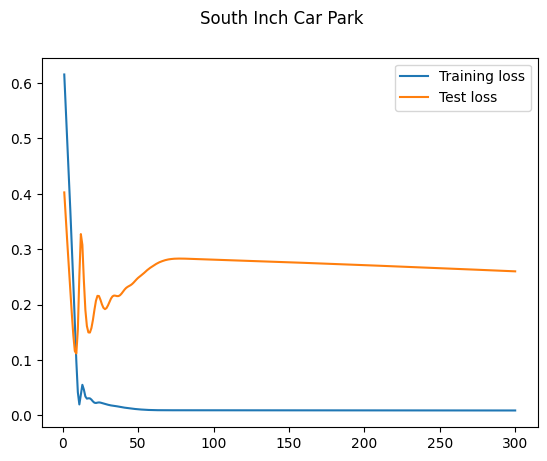

South Inch Car Park Root Mean Squared Error (RMSE): 1285.853905734328

 Kinross Park and Ride 

(36, 6, 1) (36, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0409, Test Loss: 0.1200


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/300] - Training Loss: 0.0347, Test Loss: 0.1212
Epoch [30/300] - Training Loss: 0.0212, Test Loss: 0.1470
Epoch [40/300] - Training Loss: 0.0085, Test Loss: 0.1882
Epoch [50/300] - Training Loss: 0.0059, Test Loss: 0.2164
Epoch [60/300] - Training Loss: 0.0055, Test Loss: 0.2093
Epoch [70/300] - Training Loss: 0.0052, Test Loss: 0.2083
Epoch [80/300] - Training Loss: 0.0049, Test Loss: 0.2065
Epoch [90/300] - Training Loss: 0.0047, Test Loss: 0.2047
Epoch [100/300] - Training Loss: 0.0045, Test Loss: 0.2029
Epoch [110/300] - Training Loss: 0.0043, Test Loss: 0.2010
Epoch [120/300] - Training Loss: 0.0042, Test Loss: 0.1991
Epoch [130/300] - Training Loss: 0.0040, Test Loss: 0.1973
Epoch [140/300] - Training Loss: 0.0040, Test Loss: 0.1957
Epoch [150/300] - Training Loss: 0.0039, Test Loss: 0.1941
Epoch [160/300] - Training Loss: 0.0039, Test Loss: 0.1928
Epoch [170/300] - Training Loss: 0.0039, Test Loss: 0.1917
Epoch [180/300] - Training Loss: 0.0039, Test Loss: 0.1907
Epoch

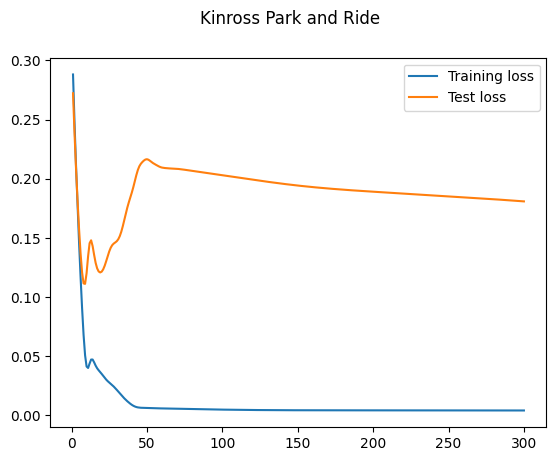

Kinross Park and Ride Root Mean Squared Error (RMSE): 3046.900845308107

 Leslie Street Car Park, Blairgowrie 

(36, 6, 1) (36, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0425, Test Loss: 0.1771


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/300] - Training Loss: 0.0393, Test Loss: 0.1412
Epoch [30/300] - Training Loss: 0.0368, Test Loss: 0.1423
Epoch [40/300] - Training Loss: 0.0349, Test Loss: 0.1417
Epoch [50/300] - Training Loss: 0.0335, Test Loss: 0.1399
Epoch [60/300] - Training Loss: 0.0325, Test Loss: 0.1381
Epoch [70/300] - Training Loss: 0.0317, Test Loss: 0.1369
Epoch [80/300] - Training Loss: 0.0311, Test Loss: 0.1362
Epoch [90/300] - Training Loss: 0.0305, Test Loss: 0.1360
Epoch [100/300] - Training Loss: 0.0299, Test Loss: 0.1363
Epoch [110/300] - Training Loss: 0.0292, Test Loss: 0.1369
Epoch [120/300] - Training Loss: 0.0284, Test Loss: 0.1381
Epoch [130/300] - Training Loss: 0.0275, Test Loss: 0.1399
Epoch [140/300] - Training Loss: 0.0264, Test Loss: 0.1429
Epoch [150/300] - Training Loss: 0.0250, Test Loss: 0.1479
Epoch [160/300] - Training Loss: 0.0235, Test Loss: 0.1559
Epoch [170/300] - Training Loss: 0.0219, Test Loss: 0.1679
Epoch [180/300] - Training Loss: 0.0206, Test Loss: 0.1832
Epoch

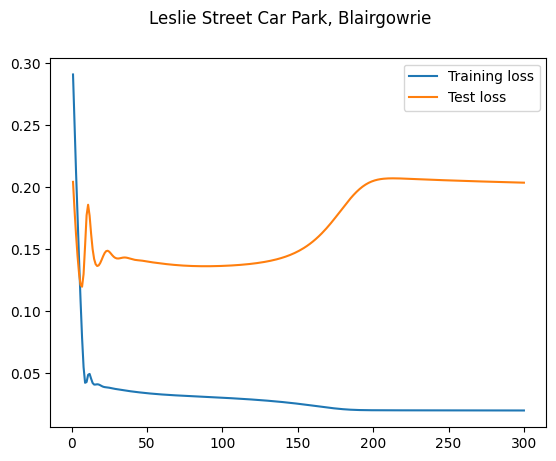

Leslie Street Car Park, Blairgowrie Root Mean Squared Error (RMSE): 785.2286825841576

 Canal Street Car Park 

(25, 6, 1) (25, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.1544, Test Loss: 0.0760
Epoch [20/300] - Training Loss: 0.0166, Test Loss: 0.1667


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/300] - Training Loss: 0.0151, Test Loss: 0.1836
Epoch [40/300] - Training Loss: 0.0152, Test Loss: 0.1577
Epoch [50/300] - Training Loss: 0.0149, Test Loss: 0.1667
Epoch [60/300] - Training Loss: 0.0149, Test Loss: 0.1682
Epoch [70/300] - Training Loss: 0.0149, Test Loss: 0.1672
Epoch [80/300] - Training Loss: 0.0148, Test Loss: 0.1669
Epoch [90/300] - Training Loss: 0.0148, Test Loss: 0.1668
Epoch [100/300] - Training Loss: 0.0148, Test Loss: 0.1668
Epoch [110/300] - Training Loss: 0.0147, Test Loss: 0.1668
Epoch [120/300] - Training Loss: 0.0147, Test Loss: 0.1667
Epoch [130/300] - Training Loss: 0.0146, Test Loss: 0.1666
Epoch [140/300] - Training Loss: 0.0146, Test Loss: 0.1664
Epoch [150/300] - Training Loss: 0.0146, Test Loss: 0.1663
Epoch [160/300] - Training Loss: 0.0145, Test Loss: 0.1661
Epoch [170/300] - Training Loss: 0.0145, Test Loss: 0.1659
Epoch [180/300] - Training Loss: 0.0144, Test Loss: 0.1657
Epoch [190/300] - Training Loss: 0.0144, Test Loss: 0.1655
Epoc

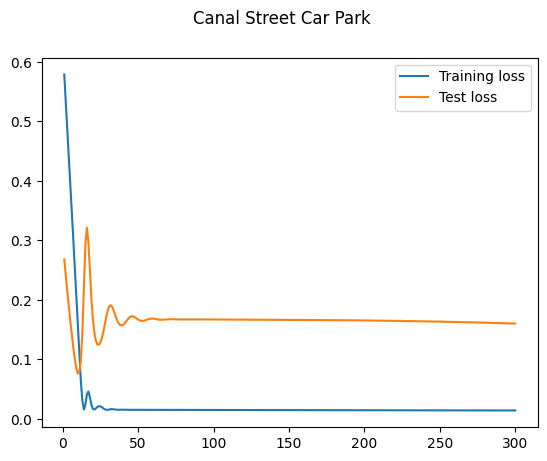

Canal Street Car Park Root Mean Squared Error (RMSE): 466.57401979714314

 King Street Car Park 

(36, 6, 1) (36, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0546, Test Loss: 0.2209


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/300] - Training Loss: 0.0307, Test Loss: 0.1600
Epoch [30/300] - Training Loss: 0.0247, Test Loss: 0.1534
Epoch [40/300] - Training Loss: 0.0197, Test Loss: 0.1526
Epoch [50/300] - Training Loss: 0.0174, Test Loss: 0.1523
Epoch [60/300] - Training Loss: 0.0169, Test Loss: 0.1520
Epoch [70/300] - Training Loss: 0.0166, Test Loss: 0.1518
Epoch [80/300] - Training Loss: 0.0164, Test Loss: 0.1516
Epoch [90/300] - Training Loss: 0.0161, Test Loss: 0.1514
Epoch [100/300] - Training Loss: 0.0159, Test Loss: 0.1512
Epoch [110/300] - Training Loss: 0.0156, Test Loss: 0.1511
Epoch [120/300] - Training Loss: 0.0153, Test Loss: 0.1510
Epoch [130/300] - Training Loss: 0.0151, Test Loss: 0.1509
Epoch [140/300] - Training Loss: 0.0148, Test Loss: 0.1509
Epoch [150/300] - Training Loss: 0.0144, Test Loss: 0.1510
Epoch [160/300] - Training Loss: 0.0141, Test Loss: 0.1512
Epoch [170/300] - Training Loss: 0.0137, Test Loss: 0.1515
Epoch [180/300] - Training Loss: 0.0134, Test Loss: 0.1519
Epoch

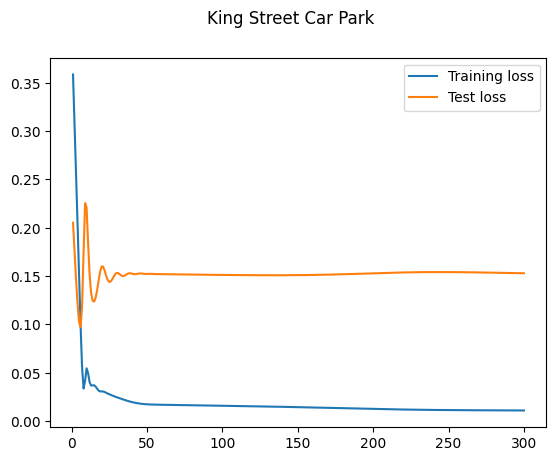

King Street Car Park Root Mean Squared Error (RMSE): 963.3046241752483

 Moness Terrace Car Park, Aberfeldy 

(36, 6, 1) (36, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0384, Test Loss: 0.1085


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/300] - Training Loss: 0.0340, Test Loss: 0.1041
Epoch [30/300] - Training Loss: 0.0284, Test Loss: 0.1150
Epoch [40/300] - Training Loss: 0.0205, Test Loss: 0.1592
Epoch [50/300] - Training Loss: 0.0152, Test Loss: 0.2816
Epoch [60/300] - Training Loss: 0.0148, Test Loss: 0.2892
Epoch [70/300] - Training Loss: 0.0145, Test Loss: 0.2761
Epoch [80/300] - Training Loss: 0.0141, Test Loss: 0.2716
Epoch [90/300] - Training Loss: 0.0138, Test Loss: 0.2651
Epoch [100/300] - Training Loss: 0.0135, Test Loss: 0.2590
Epoch [110/300] - Training Loss: 0.0132, Test Loss: 0.2525
Epoch [120/300] - Training Loss: 0.0128, Test Loss: 0.2455
Epoch [130/300] - Training Loss: 0.0125, Test Loss: 0.2380
Epoch [140/300] - Training Loss: 0.0122, Test Loss: 0.2300
Epoch [150/300] - Training Loss: 0.0119, Test Loss: 0.2217
Epoch [160/300] - Training Loss: 0.0116, Test Loss: 0.2133
Epoch [170/300] - Training Loss: 0.0114, Test Loss: 0.2051
Epoch [180/300] - Training Loss: 0.0112, Test Loss: 0.1974
Epoch

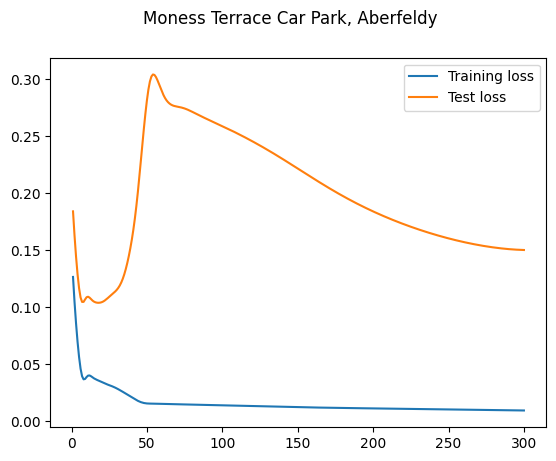

Moness Terrace Car Park, Aberfeldy Root Mean Squared Error (RMSE): 715.7891886064357

 Atholl Street Car Park, Dunkeld 

(24, 6, 1) (24, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.1512, Test Loss: 0.1050
Epoch [20/300] - Training Loss: 0.0623, Test Loss: 0.1405


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/300] - Training Loss: 0.0463, Test Loss: 0.1048
Epoch [40/300] - Training Loss: 0.0399, Test Loss: 0.1221
Epoch [50/300] - Training Loss: 0.0342, Test Loss: 0.1392
Epoch [60/300] - Training Loss: 0.0305, Test Loss: 0.1528
Epoch [70/300] - Training Loss: 0.0293, Test Loss: 0.1621
Epoch [80/300] - Training Loss: 0.0286, Test Loss: 0.1622
Epoch [90/300] - Training Loss: 0.0280, Test Loss: 0.1598
Epoch [100/300] - Training Loss: 0.0274, Test Loss: 0.1585
Epoch [110/300] - Training Loss: 0.0267, Test Loss: 0.1576
Epoch [120/300] - Training Loss: 0.0259, Test Loss: 0.1565
Epoch [130/300] - Training Loss: 0.0250, Test Loss: 0.1554
Epoch [140/300] - Training Loss: 0.0241, Test Loss: 0.1541
Epoch [150/300] - Training Loss: 0.0230, Test Loss: 0.1526
Epoch [160/300] - Training Loss: 0.0220, Test Loss: 0.1508
Epoch [170/300] - Training Loss: 0.0209, Test Loss: 0.1485
Epoch [180/300] - Training Loss: 0.0200, Test Loss: 0.1459
Epoch [190/300] - Training Loss: 0.0192, Test Loss: 0.1429
Epoc

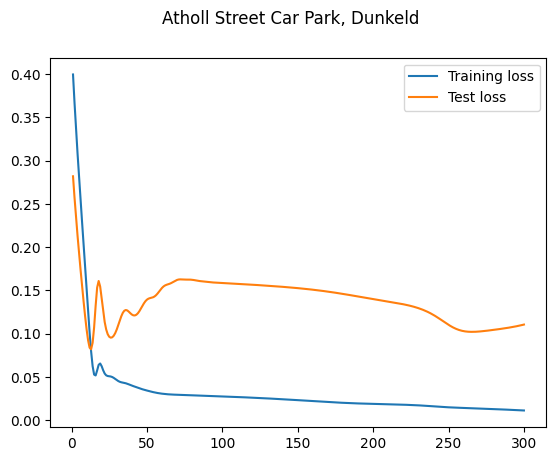

Atholl Street Car Park, Dunkeld Root Mean Squared Error (RMSE): 452.58073643051506

 Rie-Achan Road Car Park, Pitlochry 

(36, 6, 1) (36, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0268, Test Loss: 0.1400


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/300] - Training Loss: 0.0277, Test Loss: 0.1241
Epoch [30/300] - Training Loss: 0.0246, Test Loss: 0.1328
Epoch [40/300] - Training Loss: 0.0211, Test Loss: 0.1435
Epoch [50/300] - Training Loss: 0.0174, Test Loss: 0.1637
Epoch [60/300] - Training Loss: 0.0157, Test Loss: 0.1881
Epoch [70/300] - Training Loss: 0.0154, Test Loss: 0.1871
Epoch [80/300] - Training Loss: 0.0152, Test Loss: 0.1818
Epoch [90/300] - Training Loss: 0.0150, Test Loss: 0.1782
Epoch [100/300] - Training Loss: 0.0148, Test Loss: 0.1742
Epoch [110/300] - Training Loss: 0.0146, Test Loss: 0.1704
Epoch [120/300] - Training Loss: 0.0144, Test Loss: 0.1667
Epoch [130/300] - Training Loss: 0.0143, Test Loss: 0.1633
Epoch [140/300] - Training Loss: 0.0142, Test Loss: 0.1601
Epoch [150/300] - Training Loss: 0.0141, Test Loss: 0.1571
Epoch [160/300] - Training Loss: 0.0140, Test Loss: 0.1545
Epoch [170/300] - Training Loss: 0.0139, Test Loss: 0.1521
Epoch [180/300] - Training Loss: 0.0138, Test Loss: 0.1499
Epoch

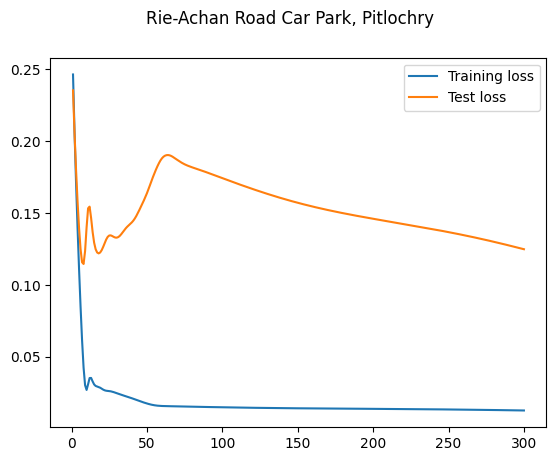

Rie-Achan Road Car Park, Pitlochry Root Mean Squared Error (RMSE): 1105.304473851348

 Friarton Depot 

(36, 6, 1) (36, 1) (6, 6, 1) (6, 1)
Epoch [10/300] - Training Loss: 0.0345, Test Loss: 0.2751


c:\Users\balda\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/300] - Training Loss: 0.0243, Test Loss: 0.1704
Epoch [30/300] - Training Loss: 0.0239, Test Loss: 0.1580
Epoch [40/300] - Training Loss: 0.0236, Test Loss: 0.1544
Epoch [50/300] - Training Loss: 0.0232, Test Loss: 0.1530
Epoch [60/300] - Training Loss: 0.0230, Test Loss: 0.1524
Epoch [70/300] - Training Loss: 0.0228, Test Loss: 0.1517
Epoch [80/300] - Training Loss: 0.0227, Test Loss: 0.1508
Epoch [90/300] - Training Loss: 0.0225, Test Loss: 0.1498
Epoch [100/300] - Training Loss: 0.0224, Test Loss: 0.1487
Epoch [110/300] - Training Loss: 0.0223, Test Loss: 0.1475
Epoch [120/300] - Training Loss: 0.0222, Test Loss: 0.1462
Epoch [130/300] - Training Loss: 0.0220, Test Loss: 0.1448
Epoch [140/300] - Training Loss: 0.0219, Test Loss: 0.1433
Epoch [150/300] - Training Loss: 0.0217, Test Loss: 0.1417
Epoch [160/300] - Training Loss: 0.0216, Test Loss: 0.1400
Epoch [170/300] - Training Loss: 0.0214, Test Loss: 0.1381
Epoch [180/300] - Training Loss: 0.0212, Test Loss: 0.1362
Epoch

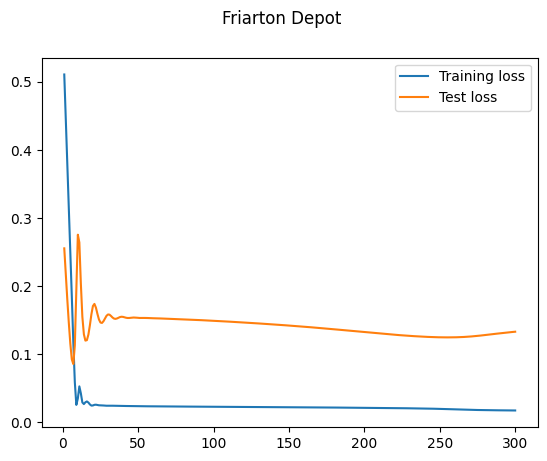

Friarton Depot Root Mean Squared Error (RMSE): 323.6989617416025


In [126]:
train_lstm(df_dict=stations_dict, type='monthly', sequence_length=6, stations=stations, 
           num_epochs=300, predictions_dict=monthly_predictions_dict, test_obs=6)

In [127]:
# File path to save the dictionary
file_path = 'monthly_predictions_perth.pkl'

# Save the dictionary to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(monthly_predictions_dict, file)

print(f"Dictionary saved to '{file_path}'")

Dictionary saved to 'monthly_predictions_perth.pkl'


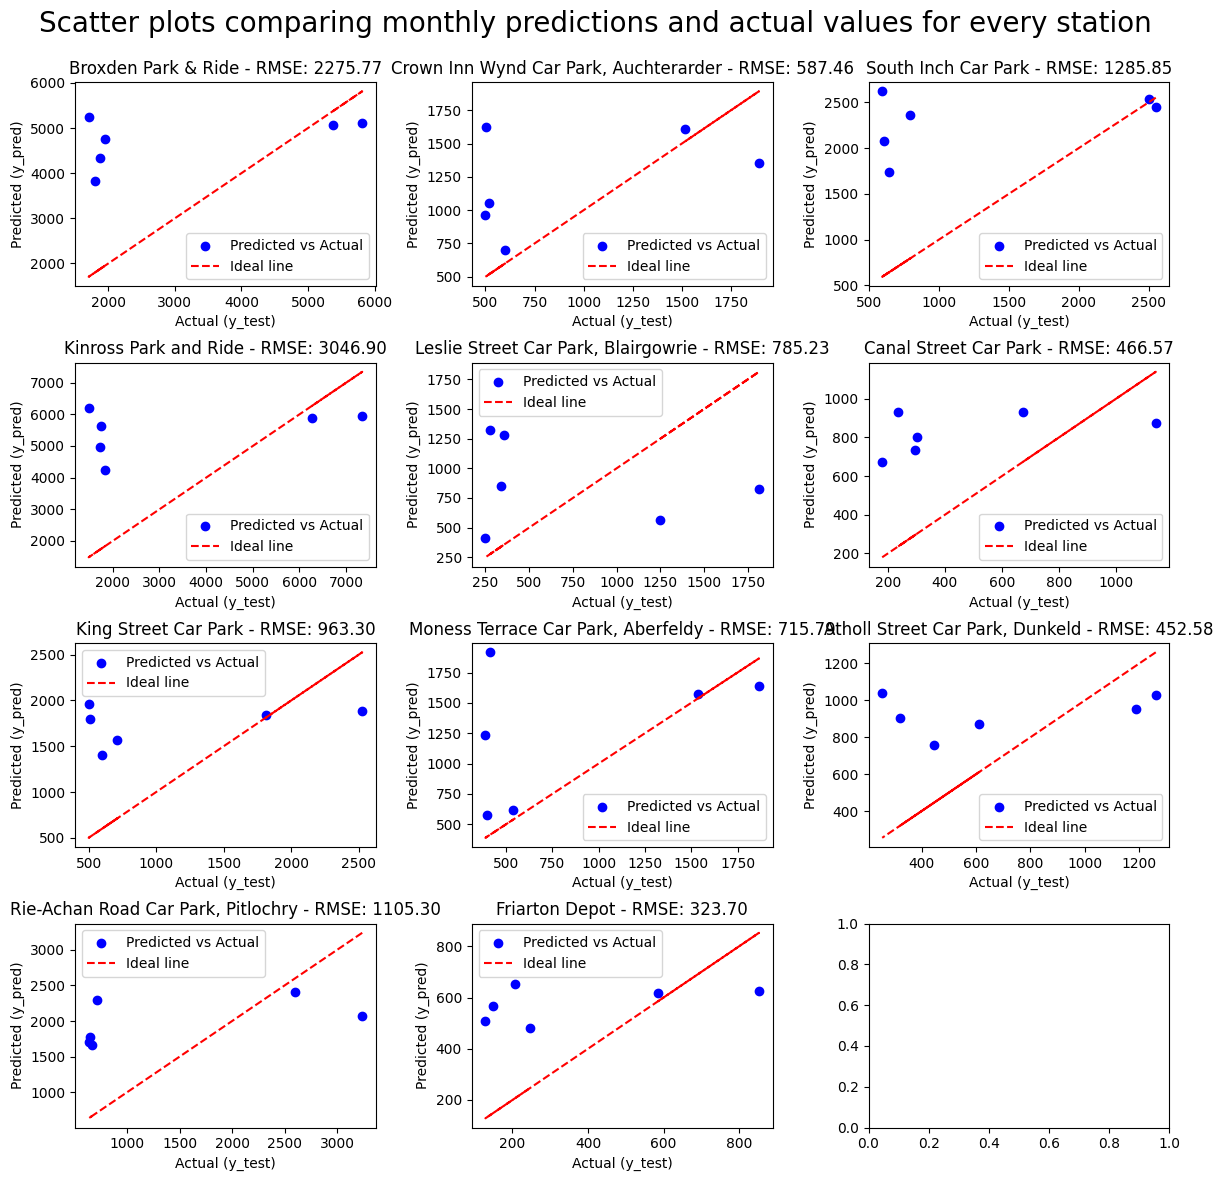

In [128]:
# Define the number of rows and columns for subplots
n_rows = 4
n_cols = 3

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(monthly_predictions_dict.keys()):
    # Get data for the current station
    station_data = monthly_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot y_pred against y_test
    axs[i].scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
    axs[i].plot(y_test, y_test, color='red', linestyle='--', label='Ideal line')

    axs[i].set_title(f'{station} - RMSE: {rmse:.2f}')
    axs[i].set_xlabel('Actual (y_test)')
    axs[i].set_ylabel('Predicted (y_pred)')
    axs[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Scatter plots comparing monthly predictions and actual values for every station', fontsize=20)
plt.show()

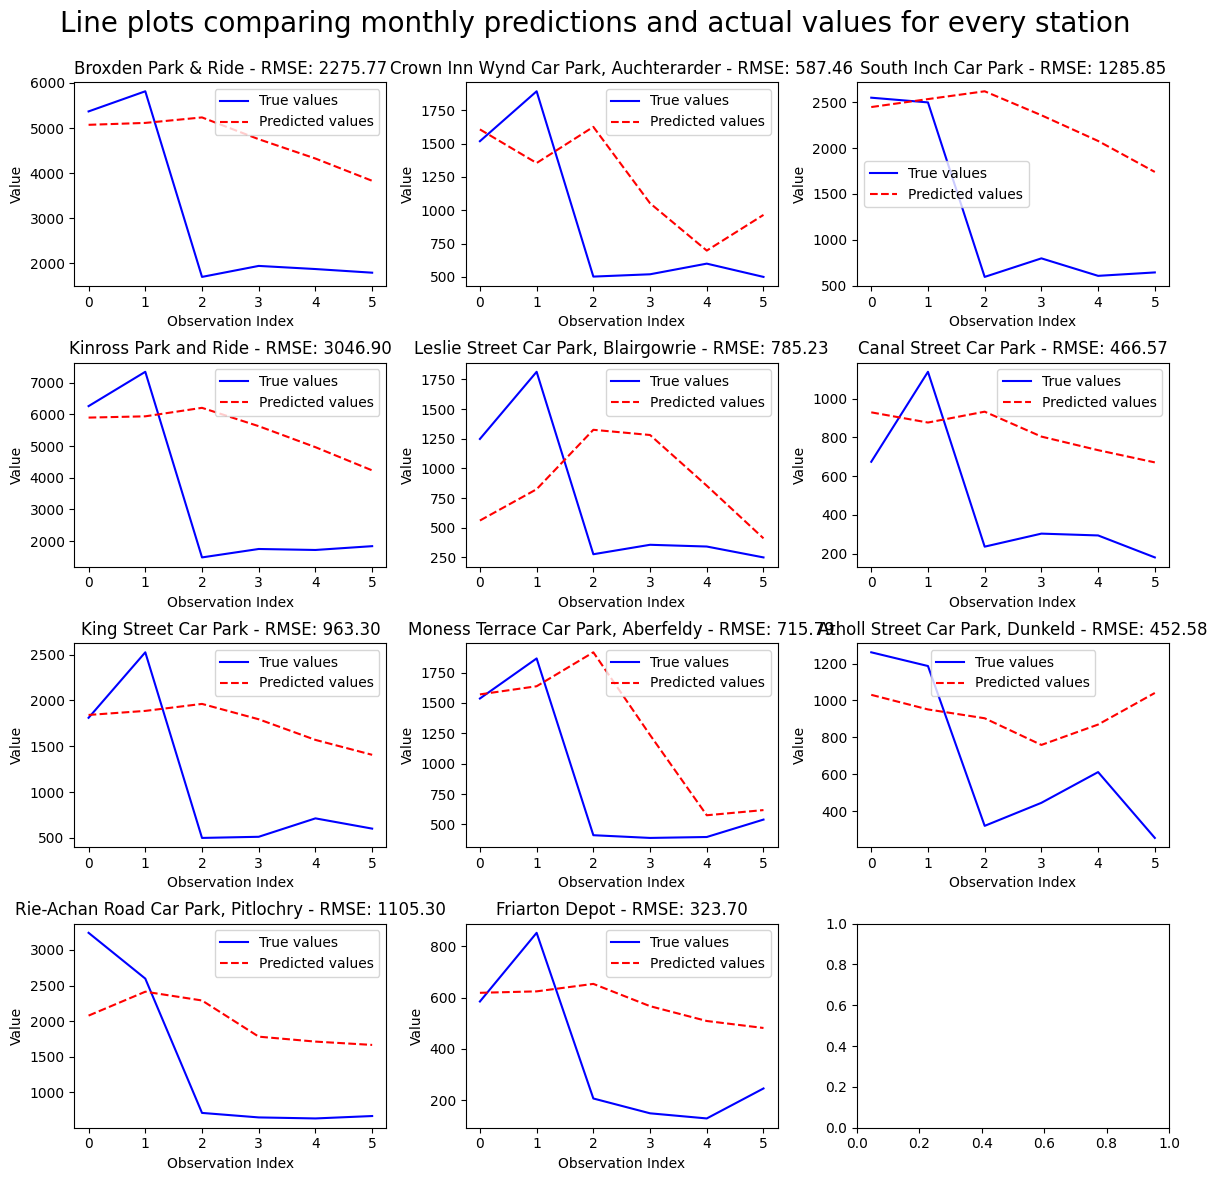

In [129]:
# Define the number of rows and columns for subplots
n_rows = 4
n_cols = 3

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Iterate over each station
for i, station in enumerate(monthly_predictions_dict.keys()):
    # Get data for the current station
    station_data = monthly_predictions_dict[station]
    y_test = station_data['y_test']
    y_pred = station_data['y_pred']
    rmse = station_data['rmse']

    # Plot true values and predicted values against the index of observations
    x = np.arange(len(y_test))
    axs[i].plot(x, y_test, color='blue', label='True values')
    axs[i].plot(x, y_pred, color='red', linestyle='--', label='Predicted values')

    axs[i].set_title(f'{station} - RMSE: {rmse:.2f}')
    axs[i].set_xlabel('Observation Index')
    axs[i].set_ylabel('Value')
    axs[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Line plots comparing monthly predictions and actual values for every station', fontsize=20)
plt.show()


Monthly predictions are no different from the rest. Maybe for one or two stations the forecasts are slightly better but all in all a dissapointing results again.

## 4. Conclusion

Although the LSTM model proved to be adequate to forceast energy demand in Palo Alto, it does not perform well in case of Perth. This is obviousely caused by the data quality of Perth dataset. To many missing values biased the timeseries of energy demand and the model was unable to produce decent forecasts. Arguably hardly any model would live up to the task. As the saying goes "garbage in garbage out".